## **Avellaneda-Stoikov Market-Making Implementations Comparison**

The Avellaneda-Stoikov model for market-making allows to provide liquidity optimally while managing inventory risk through the notion of reservations prices and computing the optimal bid-ask spread each time, depending on the inventory and other parameters. This model has become very famous given its application to a high-frequency trading setting, and many extensions and implementations have been derived for its practical usage.

The aim of this notebook project is to program and simulate different versions of the Avellaneda-Stoikov model in order to have a numerical and graphical comparison and to study the effect of the different parameters. Specifically, we will look at the following implementations:

- The Avellaneda-Stoikov Model Implementation ($o$)
- The Avellaneda-Stoikov Model Implementation when there is a risk limit. ($b$)
- The Avellaneda-Stoikov Model Implementation when there is a risk limit and a drift. ($bu$)
- The Avellaneda-Stoikov Model Implementation when there is a risk limit and a jump process. ($bj$)
- The Approximation of the Avellaneda-Stoikov Model Implementation when there is a risk limit and an infinite trading horizon. ($bi$)
- The Approximation of the Avellaneda-Stoikov Model Implementation when there is a risk limit, a drift and an infinite trading horizon. ($biu$)
- The Approximation of the Avellaneda-Stoikov Model Implementation when there is a risk limit, a jump process and an infinite trading horizon. ($bij$)

For all of these implementations there will be graphical representations of the market-maker algorithm and the price process and summary tables with relevant numerical results.

#### **Necessary Libraries \& Data**

First of all, we download the necessary Python libraries that will be used throughout the code and the data that we will use to estimate some parameters of our models and backtest our results. We normalize the data to base 100 in order to keep results easily interpretable.

In [7]:
# Libraries

import math
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm
import os

# Data

file_path = os.path.join('..', 'BTCUSDT.csv')
df = pd.read_csv(file_path)
initial_mid_price = df['Mid-Price'].iloc[0]
df['Mid-Price'] = df['Mid-Price'] / initial_mid_price * 100
df['OrderBook_Bid'] = df['OrderBook_Bid'] / initial_mid_price * 100
df['OrderBook_Ask'] = df['OrderBook_Ask'] / initial_mid_price * 100

#### **The Market-Making Bots**

In order to compare these different implementations, we code an automated trading bot which implements the different versions of the Avellaneda-Stoikov Model, called AveStoikov(), and another automated trading bot which implements a common market-making strategy such as symmetric quoting, called Symm(). The latter will serve as a bennchmark.

These bots have a method for computing the optimal bid and ask prices through the pricing formulas derived from the different models (a pair of formulae for each version of the Avellaneda-Stoikov model) and the resulting spread.

In [8]:
# Avellaneda-Stoikov Bot

class AveStoikov(object):

    def __init__(self, gamma, k, A=1, Q=0, eps=1, mod: str = "o"):

        models = ["o","i","b","bu","bj","bi","biu","bij","abiu","abij"]
        
        self._gamma = gamma
        self._k = k
        self._Q = Q
        self._A = A
        self._eps = eps

        if mod in models:
            self._mod = mod
        else:
            print('You must choose a model between "o", "i", "b", "bu", "bj", "bi", "biu" or "bij"')

    def __str__(self):

        return f"Avellaneda-Stoikov Market-Making Bot '{self._mod}'\n\nParameters:\n\ngamma={self._gamma}, k={self._k}, A={self._A}, Q={self._Q}, eta={self._eps}"
    
    def vt_creation(self,sigma,T,t,M):

        alpha = (self._k/2)*self._gamma*(sigma**2)
        eta = self._A*(1+self._gamma/self._k)**(-(1+self._k/self._gamma))
        size = 2*self._Q+1
        matrix_m = np.zeros((size,size))

        for i in range(size):
            if i - 1 >= 0:
                matrix_m[i, i - 1] = -eta    
            if i + 1 < size:                
                matrix_m[i, i + 1] = -eta
            matrix_m[i,i] = alpha * (i - self._Q)**2

        ones_vector = np.ones(size)
        exp_matrix = expm(-matrix_m * (T - t/M))

        v_t = np.dot(exp_matrix, ones_vector)

        return list(v_t)

    def opt_bidask(self,S,sigma,q,T,t,M,v: list,mu=0):

        if self._mod=="o":

            bid = S - self._gamma*(sigma**2)*(T-(t/M))*(q+1/2)-(1/self._gamma)*math.log(1+(self._gamma/self._k))
            ask = S - self._gamma*(sigma**2)*(T-(t/M))*(q-1/2)+(1/self._gamma)*math.log(1+(self._gamma/self._k))
            return bid, ask
        
        elif self._mod=="b" or self._mod=="bu":

            index = int(q) + int(self._Q)

            if index<=2*self._Q:
                bid = S - (1/self._k)*math.log(v[index]/v[index+1])-(1/self._gamma)*math.log(1+(self._gamma/self._k))
                ask = S + (1/self._k)*math.log(v[index]/v[index-1])+(1/self._gamma)*math.log(1+(self._gamma/self._k))
            else:
                bid = S - (1/self._k)*math.log(v[2*self._Q]/v[2*self._Q+1])-(1/self._gamma)*math.log(1+(self._gamma/self._k))
                ask = S + (1/self._k)*math.log(v[2*self._Q]/v[2*self._Q-1])+(1/self._gamma)*math.log(1+(self._gamma/self._k))

            return bid, ask
        
        elif self._mod=="bj":

            index = int(q) + int(self._Q)

            if index<=2*self._Q:
                bid = S - (1/self._k)*math.log(v[index]/v[index+1])-self._eps/2-(1/self._gamma)*math.log(1+(self._gamma/self._k))
                ask = S + (1/self._k)*math.log(v[index]/v[index-1])+self._eps/2+(1/self._gamma)*math.log(1+(self._gamma/self._k))
            else:
                bid = S - (1/self._k)*math.log(v[2*self._Q]/v[2*self._Q+1])-self._eps/2-(1/self._gamma)*math.log(1+(self._gamma/self._k))
                ask = S + (1/self._k)*math.log(v[2*self._Q]/v[2*self._Q-1])+self._eps/2+(1/self._gamma)*math.log(1+(self._gamma/self._k))
            return bid, ask
        
        elif self._mod=="bi":

            if q<=self._Q and q>=-self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))-(1/(2*self._k))*math.sqrt(((sigma**2)*self._gamma)/(2*self._k*self._A))*(2*q+1)
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))-(1/(2*self._k))*math.sqrt(((sigma**2)*self._gamma)/(2*self._k*self._A))*(2*q-1)
            elif q>self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))-(1/(2*self._k))*math.sqrt(((sigma**2)*self._gamma)/(2*self._k*self._A))*(2*self._Q+1)
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))-(1/(2*self._k))*math.sqrt(((sigma**2)*self._gamma)/(2*self._k*self._A))*(2*self._Q-1)
            elif q<-self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))-(1/(2*self._k))*math.sqrt(((sigma**2)*self._gamma)/(2*self._k*self._A))*(2*(-self._Q)+1)
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))-(1/(2*self._k))*math.sqrt(((sigma**2)*self._gamma)/(2*self._k*self._A))*(2*(-self._Q)-1)
            return bid, ask
        
        elif self._mod=="biu":

            if q<=self._Q and q>=-self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))+(-(mu/(self._gamma*self._k))+(2*q+1)/2)*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))+(mu/(self._gamma*self._k)-(2*q-1)/2)*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
            elif q>self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))+(-(mu/(self._gamma*self._k))+(2*self._Q+1)/2)*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))+(mu/(self._gamma*self._k)-(2*self._Q-1)/2)*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
            elif q<-self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))+(-(mu/(self._gamma*self._k))+(2*(-self._Q)+1)/2)*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))+(mu/(self._gamma*self._k)-(2*(-self._Q)-1)/2)*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
            return bid, ask
        
        elif self._mod=="bij":

            if q<=self._Q and q>=-self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))-self._eps/2-((2*q+1)/2)*(math.exp((self._k*self._eps)/4))*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))+self._eps/2-((2*q-1)/2)*(math.exp((self._k*self._eps)/4))*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
            elif q>self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))-self._eps/2-((2*self._Q+1)/2)*(math.exp((self._k*self._eps)/4))*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))+self._eps/2-((2*self._Q-1)/2)*(math.exp((self._k*self._eps)/4))*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
            elif q<-self._Q:
                bid = S - (1/self._k)*math.log(1+(self._gamma/self._k))-self._eps/2-((2*(-self._Q)+1)/2)*(math.exp((self._k*self._eps)/4))*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
                ask = S + (1/self._k)*math.log(1+(self._gamma/self._k))+self._eps/2-((2*(-self._Q)-1)/2)*(math.exp((self._k*self._eps)/4))*math.sqrt((((sigma**2)*self._gamma)/(2*self._k*self._A))*(1+(self._gamma/self._k))**(1+(self._k/self._gamma)))
            return bid, ask
        
    def strat_spread(self,bid,ask):

        sp = ask-bid
        return sp
    
# Symmetric Quoting Bot

class Symm(object):

    def __init__(self,spread):

        self._spread = spread

    def bid_ask(self,mid_price):

        bid = mid_price - self._spread/2
        ask = mid_price + self._spread/2
        return bid, ask

#### **Trading simulation \& Backtesting**

We define functions in order to simulate the execution of orders and perform backtesting by taking into account the statistical results of econophysics, which are central to the Avellaneda-Stoikov model. 

In [9]:
def sim_trad(S,bid,ask,k,A,T,M):

    dt = T/M

    delta_bid = S-bid
    delta_ask = ask-S

    lambda_bid = A*math.exp(-k*delta_bid)
    prob_bid = 1 - math.exp(-lambda_bid*dt)
    fbid = random.random()

    lambda_ask = A*math.exp(-k*delta_ask)
    prob_ask = 1 - math.exp(-lambda_ask*dt)
    fask = random.random()

    exec_buy = prob_bid > fbid
    exec_sell = prob_ask > fask

    return exec_buy, exec_sell

def backtest_order(ob_bid,ob_ask,bid,ask,k,A,T,M):

    dt=T/M

    delta_bid = ob_bid - bid
    delta_ask = ask - ob_ask

    lambda_bid = A*math.exp(-k*delta_bid)
    lambda_ask = A*math.exp(-k*delta_ask)

    prob_bid = 1 - math.exp(-lambda_bid*dt)
    prob_ask = 1 - math.exp(-lambda_ask*dt)

    fbid = random.random()
    fask = random.random()

    exec_buy = prob_bid > fbid
    exec_sell = prob_ask > fask

    return exec_buy, exec_sell

#### **Choose the parameters for the simulations and backtests**

These parameters can be estimated from the data or can be defined by the user. They are applied to all the Avellaneda-Stoikov bots used in the code, so that results can be compared.

In [10]:
random.seed(2945)

gamma1 = 0.1
k1 = 1.5
A1 = 140
Q1 = 10
sigma1 = 5
eps1 = 2
T1 = 1
M1 = len(df) - 1
mu1 = 3
s0 = df["Mid-Price"].iloc[0]

#### **The Avellaneda-Stoikov Model Implementation ($o$)**

This is the original Avellaneda-Stoikov model, as defined by Avellaneda and Stoikov (2008). The most important aspects of the modell are the following:

1. Let $(\Omega, \mathcal{F}, \mathbb{P})$ be the probability space where all variables are defined and $(\mathcal{F})_{t \geq 0}$ to be a filtration with the usual conditions. The stock prices $S$ evolves respecting the diffusion process $$dS_t = \sigma dW_t$$ where $W$ is a brownian motion and $\sigma$ is the volatility parameter for the prices.

2. The inventory of the market-maker is $$q_t=N^{b}_t-N^{a}_t$$ where $N^b$ and $N^{a}$ are the point processes independent of $(W_t)_{t \geq 0}$ which give the number of bought and sold assets, respectively.

3. Arrival rates of these processes depend on $S_t^{a}$ and $S_t^{b}$ and intensities $\lambda^{a}$ and $\lambda^{b}$ associted respectively with $N^{a}$ and $N^{b}$ depend on the difference between quoted and midpoint prices $\delta^{a}=S_t^{a}-S_t$ and $\delta^{b}=S_t-S_t^{b}$ with the form
$$
\lambda^{i} (\delta^{i}) = A\exp{(-k \delta^{i})}\quad\text{for }i\in\{1,2\}
$$

4. The cash of the market-maker evolves according to $$dX_t = (S_t+\delta^{a})dN^{a}_t-(S_t-\delta^{b})dN^{b}_t$$ where $X$ is the amount of cash.

5. The agent's objective function is the CARA utility function $v(x,s,q)=E_t[-\exp(-\gamma(x_T+ q_T s_T))]$, so that the optimization problem is $$\sup_{(\delta^{a}_t)_t,(\delta^{b}_t)_t \in \mathcal{A}}{E_t[-\exp(-\gamma(x_T+ q_T s_T))]}$$ where $\mathcal{A}$ is the set of predictable processes bounded from below and $\gamma$ is the risk aversion coefficient.

The numerical simulation results of this model are summarized below:

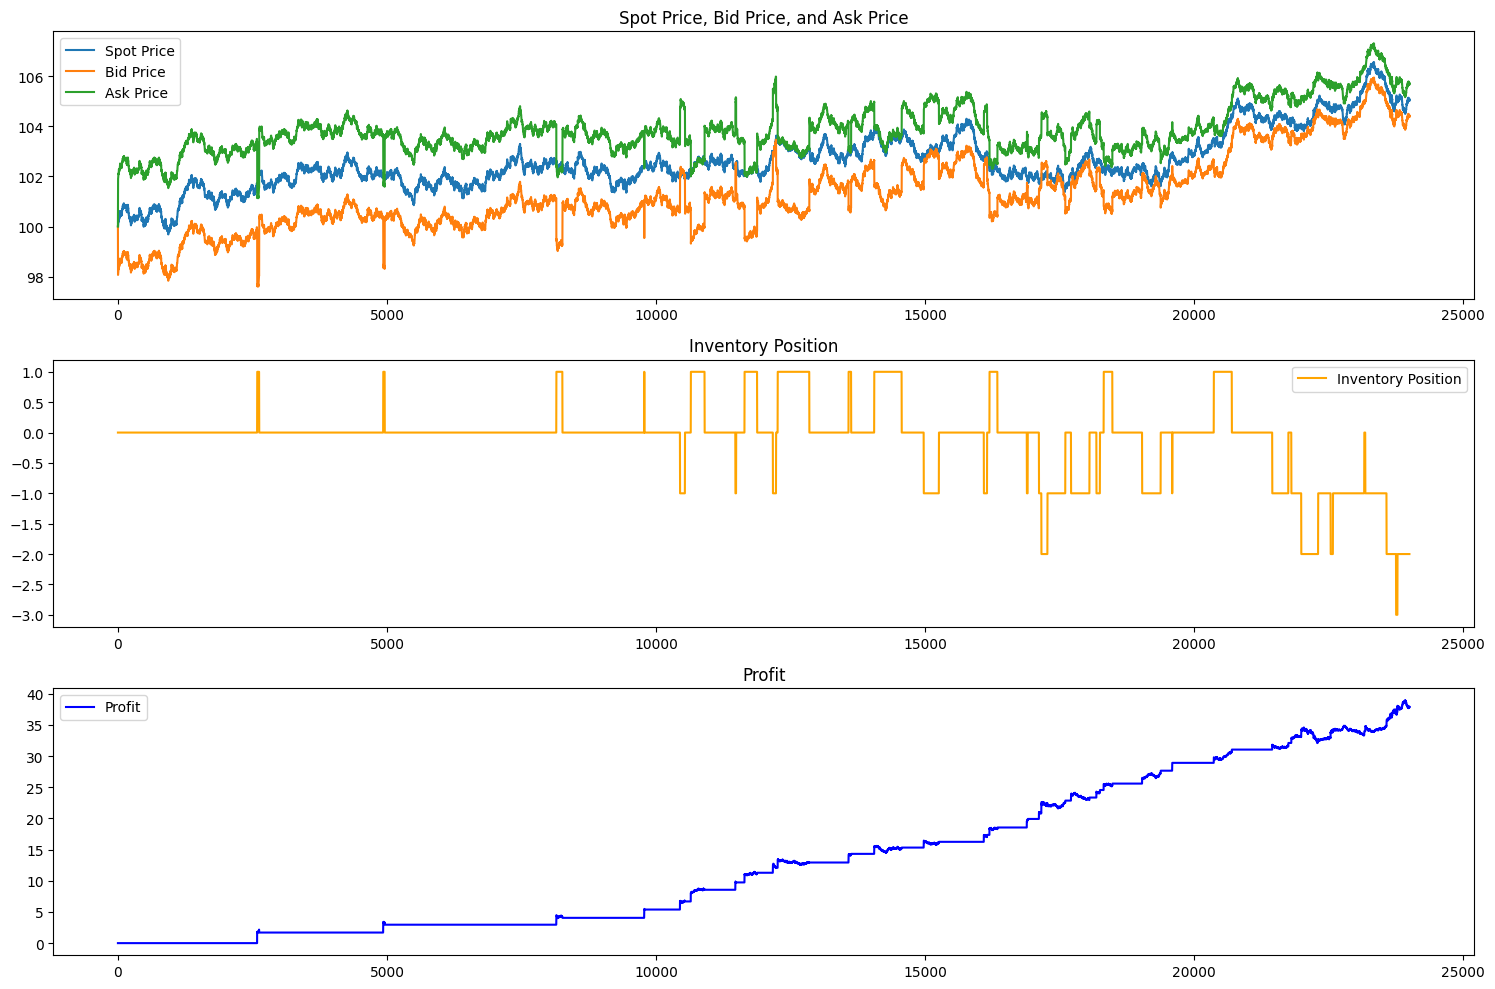

---------STATS--------


Average Spread: 2.54

Max Spread: 3.79


Average Inventory held: -0.11

Maximum Inventory held (Short or Long): 3.00


Generated Profit: 37.90

Profit StDev: 11.77


Sharpe Ratio: 3.22


In [11]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="o")

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
cash = np.zeros(M1+1)
profit = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
q[0] = 0
cash[0] = 0
profit[0] = 0

for t in range(1,M1+1):

    z = np.random.randn()
    S[t] = S[t-1] + sigma1*math.sqrt((T1/M1))*z
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    executed_buy, executed_sell = sim_trad(S=S[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Spot Price, Bid Price, and Ask Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(q, label='Inventory Position', color='orange')
plt.title('Inventory Position')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(profit, label='Profit', color='blue')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}')
print(f'\n\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

We can now do backtesting with the two bots and using a cryptocurrency pair such as BTC/USDT, one of the most important ones. The results are the following:

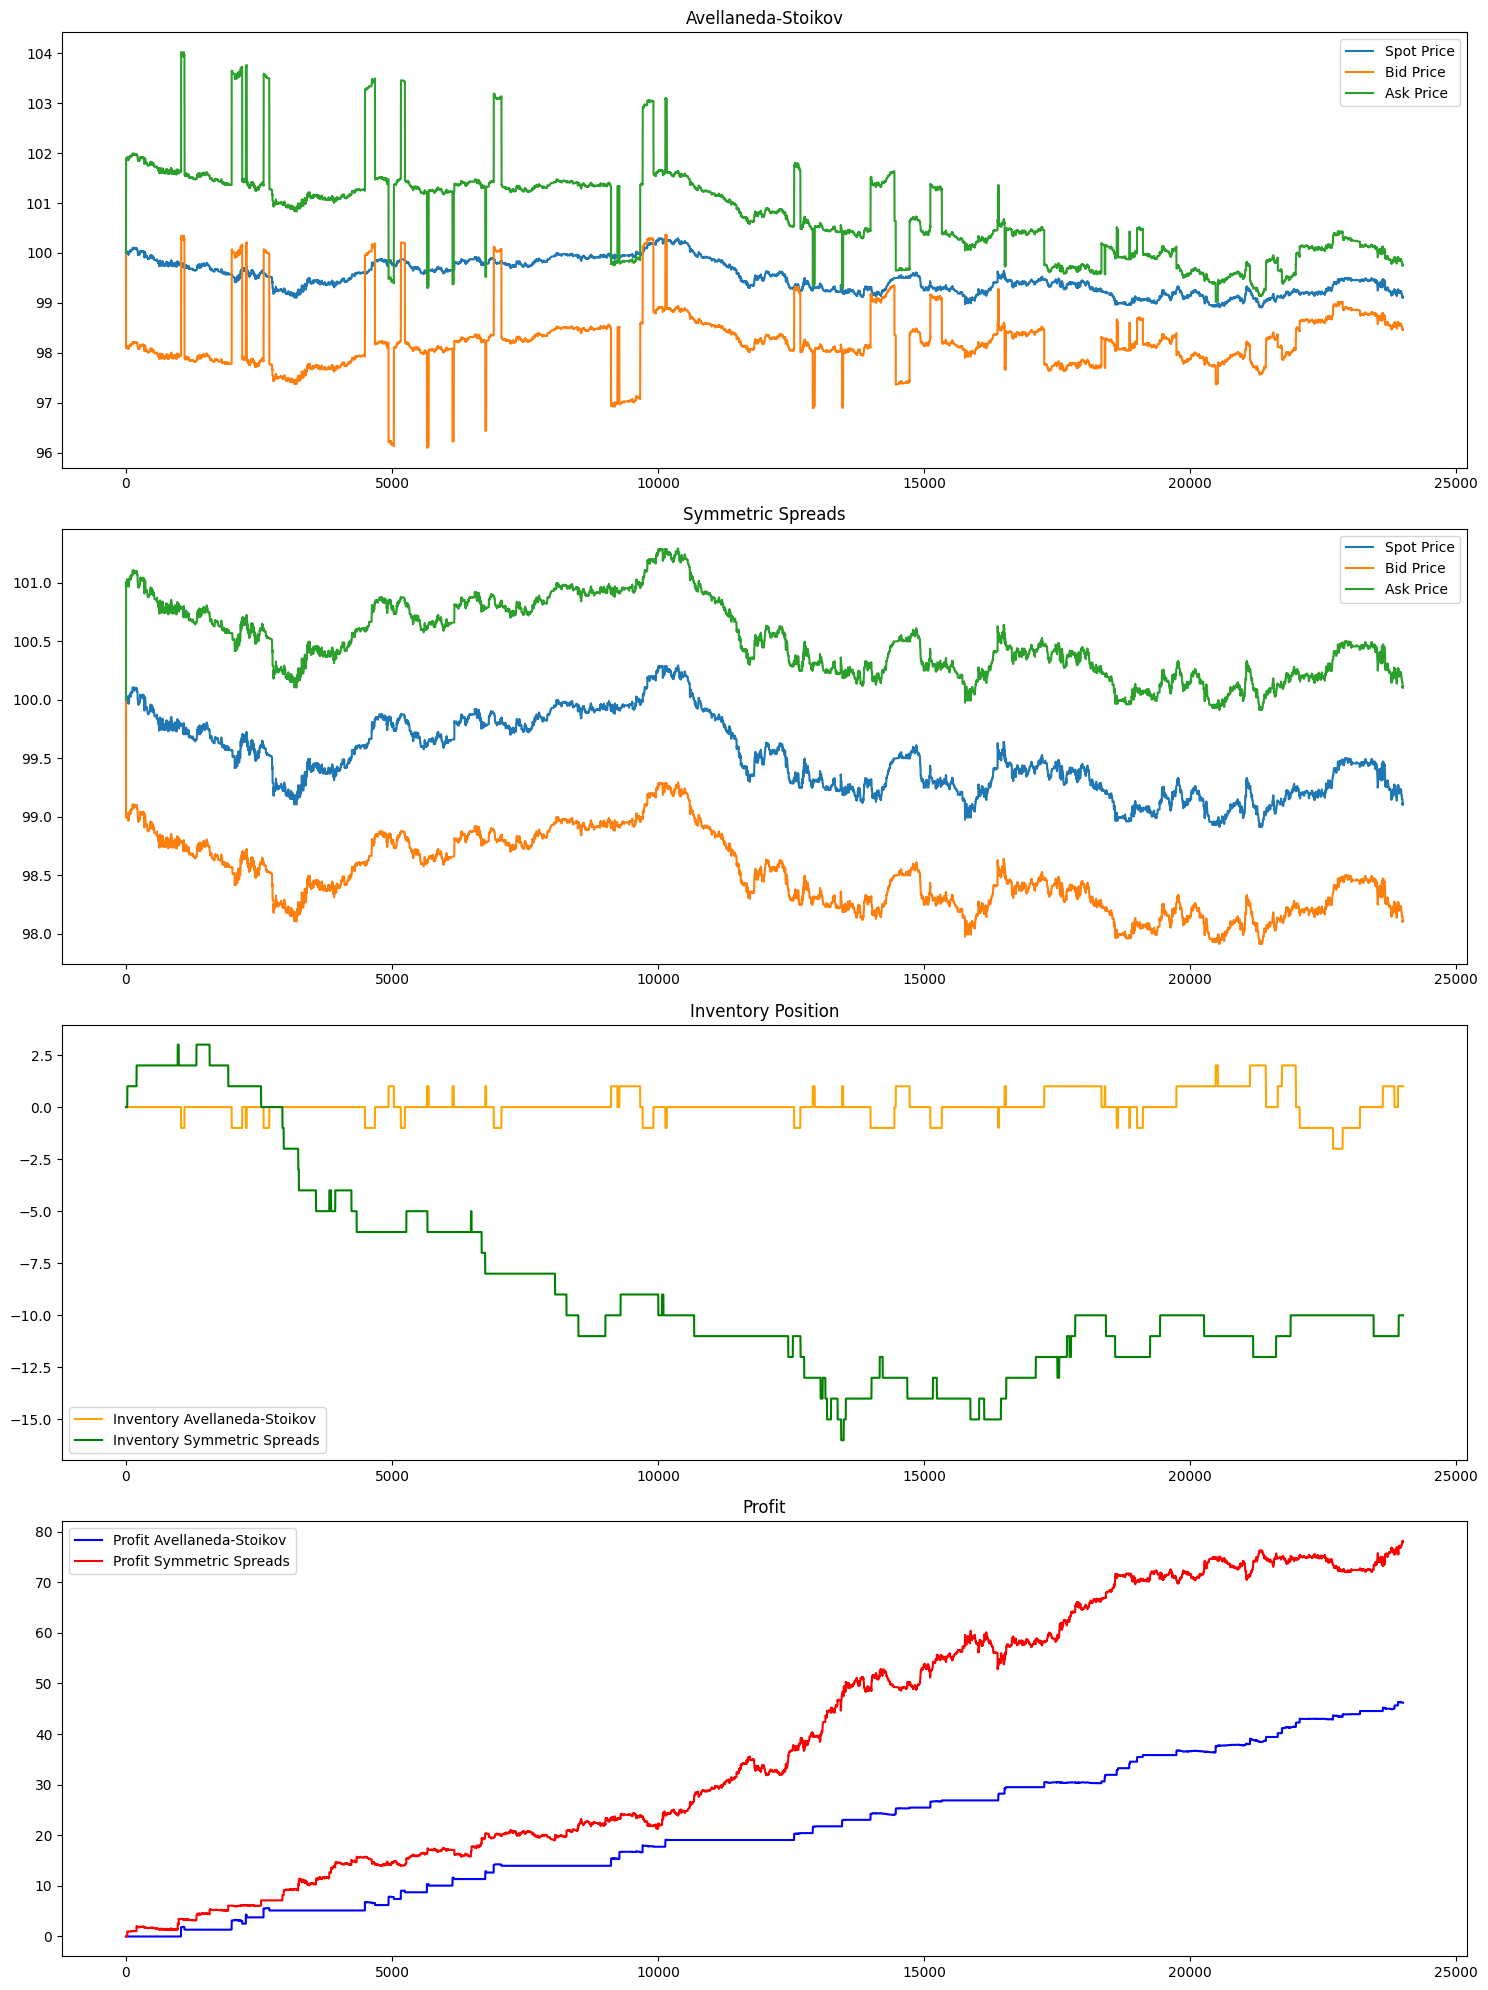

---------STATS--AS---------


Average Spread: 2.54

Max Spread: 3.79


Average Inventory held: 0.07

Maximum Inventory held (Short or Long): 2.00


Generated Profit: 46.17

Profit StDev: 13.16


Sharpe Ratio: 3.51

---------STATS--Sym--------


Average Inventory held: -8.70

Maximum Inventory held (Short or Long): 16.00


Generated Profit: 78.07

Profit StDev: 25.23


Sharpe Ratio: 3.09


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="o")
sym_bot = Symm(spread=0.02*s0)

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
bids_sym = np.zeros(M1+1)
asks_sym = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
q_sym = np.zeros(M1+1)
cash = np.zeros(M1+1)
cash_sym = np.zeros(M1+1)
profit = np.zeros(M1+1)
profit_sym = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
bids_sym[0] = s0
asks_sym[0] = s0
q[0] = 0
q_sym[0] = 0
cash[0] = 0
cash_sym[0] = 0
profit[0] = 0
profit_sym[0] = 0

for t in range(1,M1+1):

    S[t] = df['Mid-Price'].iloc[t]
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    bids_sym[t], asks_sym[t] = sym_bot.bid_ask(S[t])
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    # Avellaneda-Stoikov Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]
    
    # Symmetric Bot

    executed_buy_sym, executed_sell_sym = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids_sym[t],ask=asks_sym[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy_sym and not executed_sell_sym:
        q_sym[t] = q_sym[t - 1] + 1
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t]

    elif not executed_buy_sym and executed_sell_sym:
        q_sym[t] = q_sym[t - 1] - 1
        cash_sym[t] = cash_sym[t - 1] + asks_sym[t]

    elif not executed_buy_sym and not executed_sell_sym:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1]

    elif executed_buy_sym and executed_sell_sym:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t] + asks_sym[t]

    profit_sym[t] = cash_sym[t] + q_sym[t] * S[t]

plt.figure(figsize=(15, 20))

# Plot S, Bids, and Asks for Avellaneda-Stoikov

plt.subplot(4, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Avellaneda-Stoikov')
plt.legend()

# Plot S, Bids, and Asks for Symmetric spreads

plt.subplot(4, 1, 2)
plt.plot(S, label='Spot Price')
plt.plot(bids_sym, label='Bid Price')
plt.plot(asks_sym, label='Ask Price')
plt.title('Symmetric Spreads')
plt.legend()

# Plot q for both strategies

plt.subplot(4, 1, 3)
plt.plot(q, label='Inventory Avellaneda-Stoikov', color='orange')
plt.plot(q_sym, label='Inventory Symmetric Spreads', color='green')
plt.title('Inventory Position')
plt.legend()

# Plot profit for both strategies

plt.subplot(4, 1, 4)
plt.plot(profit, label='Profit Avellaneda-Stoikov', color='blue')
plt.plot(profit_sym, label='Profit Symmetric Spreads', color='red')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--AS---------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}\n')
print(f'\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

print('\n---------STATS--Sym--------\n\n')


q_series = pd.Series(q_sym)

print(f'Average Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit_sym[-1]:.2f}\n')
print(f'Profit StDev: {profit_sym.std():.2f}\n')
print(f'\nSharpe Ratio: {profit_sym[-1]/profit_sym.std():.2f}')

#### **The Avellaneda-Stoikov Model Implementation when there is a risk limit ($b$)**

This is the modified Avellaneda-Stoikov model proposed by Guéant et al. (2012), which extends the results from the original paper to include a risk limitation for the inventory in its simplest version. The most important aspects are the following:

1. Let $(\Omega, \mathcal{F}, \mathbb{P})$ be the probability space where all variables are defined and $(\mathcal{F})_{t \geq 0}$ to be a filtration with the usual conditions. The stock prices $S$ evolves respecting the diffusion process $$dS_t = \sigma dW_t$$ where $W$ is a brownian motion and $\sigma$ is the volatility parameter for the prices.

2. The inventory of the market-maker is $$q_t=N^{b}_t-N^{a}_t$$ where $N^b$ and $N^{a}$ are the point processes independent of $(W_t)_{t \geq 0}$ which give the number of bought and sold assets, respectively.

3. Arrival rates of these processes depend on $S_t^{a}$ and $S_t^{b}$ and intensities $\lambda^{a}$ and $\lambda^{b}$ associted respectively with $N^{a}$ and $N^{b}$ depend on the difference between quoted and midpoint prices $\delta^{a}=S_t^{a}-S_t$ and $\delta^{b}=S_t-S_t^{b}$ with the form
$$
\lambda^{i} (\delta^{i}) = A\exp{(-k \delta^{i})}\quad\text{for }i\in\{1,2\}
$$

4. The cash of the market-maker evolves according to $$dX_t = (S_t+\delta^{a})dN^{a}_t-(S_t-\delta^{b})dN^{b}_t$$ where $X$ is the amount of cash.

5. There is a bound $Q$ for the inventory that a market-maker is authorized to have (he has a risk limit).

6. The agent's objective function is the CARA utility function $v(x,s,q)=E_t[-\exp(-\gamma(x_T+ q_T s_T))]$, so that the optimization problem is $$\sup_{(\delta^{a}_t)_t,(\delta^{b}_t)_t \in \mathcal{A}}{E_t[-\exp(-\gamma(x_T+ q_T s_T))]}$$ where $\mathcal{A}$ is the set of predictable processes bounded from below and $\gamma$ is the risk aversion coefficient.

The numerical simulation results of this model are summarized below:

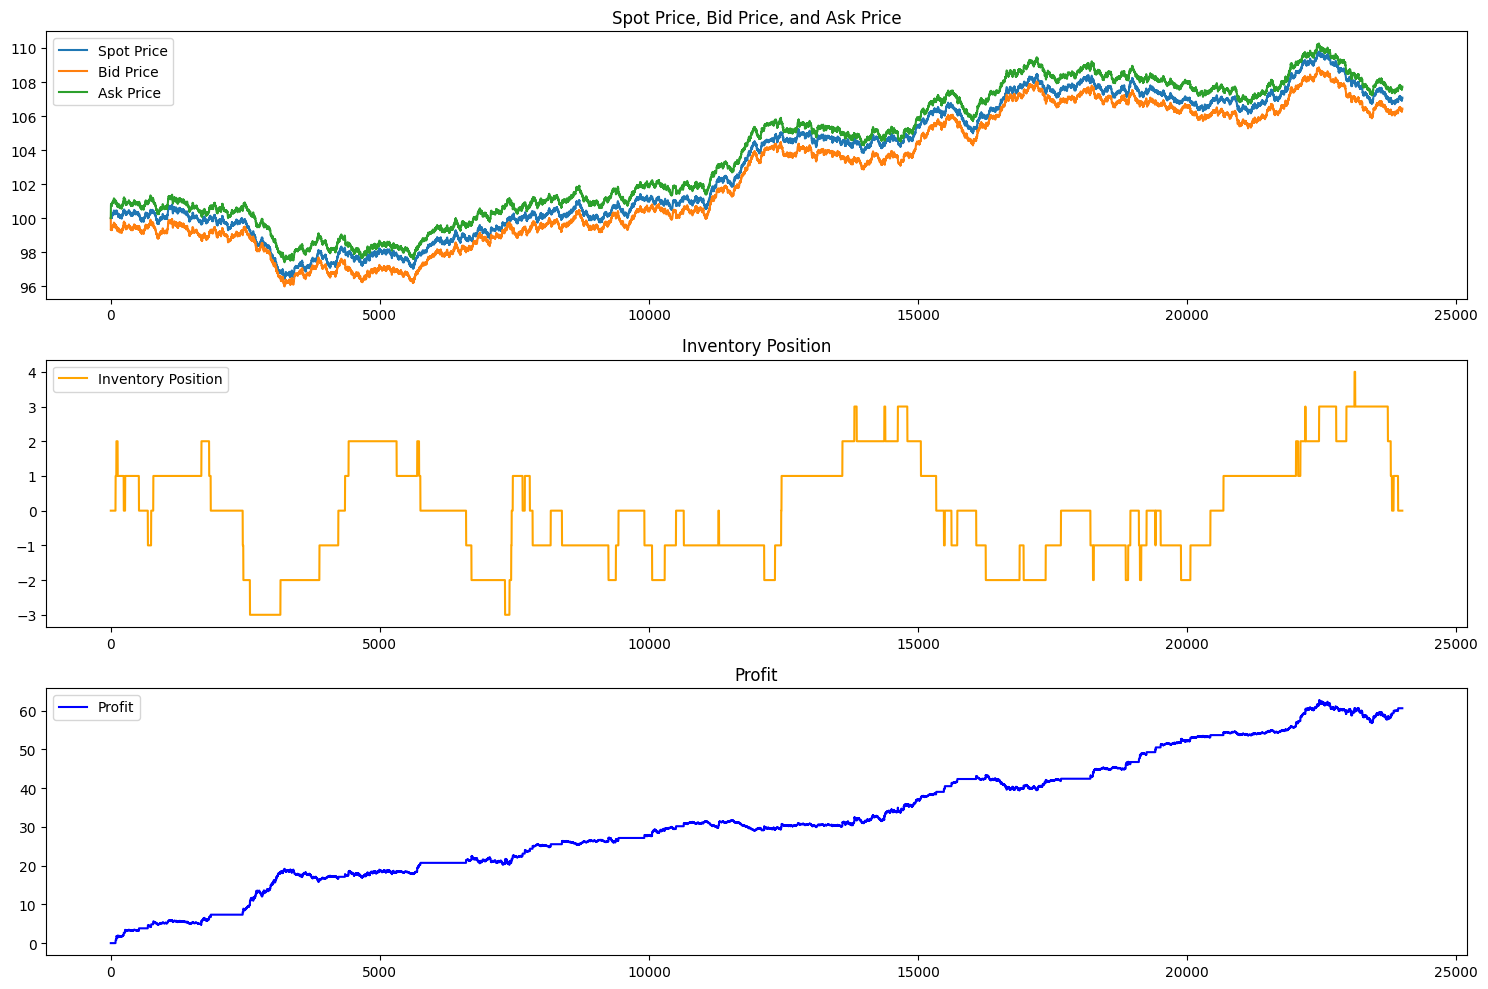

---------STATS--------


Average Spread: 1.42

Max Spread: 1.43


Average Inventory held: 0.01

Maximum Inventory held (Short or Long): 4.00


Generated Profit: 60.65

Profit StDev: 16.01


Sharpe Ratio: 3.79


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="b")

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
cash = np.zeros(M1+1)
profit = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
q[0] = 0
cash[0] = 0
profit[0] = 0


for t in range(1,M1+1):

    z = np.random.randn()
    S[t] = S[t-1] + sigma1*math.sqrt((T1/M1))*z
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    executed_buy, executed_sell = sim_trad(S=S[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Spot Price, Bid Price, and Ask Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(q, label='Inventory Position', color='orange')
plt.title('Inventory Position')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(profit, label='Profit', color='blue')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}')
print(f'\n\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

We can now do backtesting with the two bots and using a cryptocurrency pair such as BTC/USDT, one of the most important ones. The results are the following:

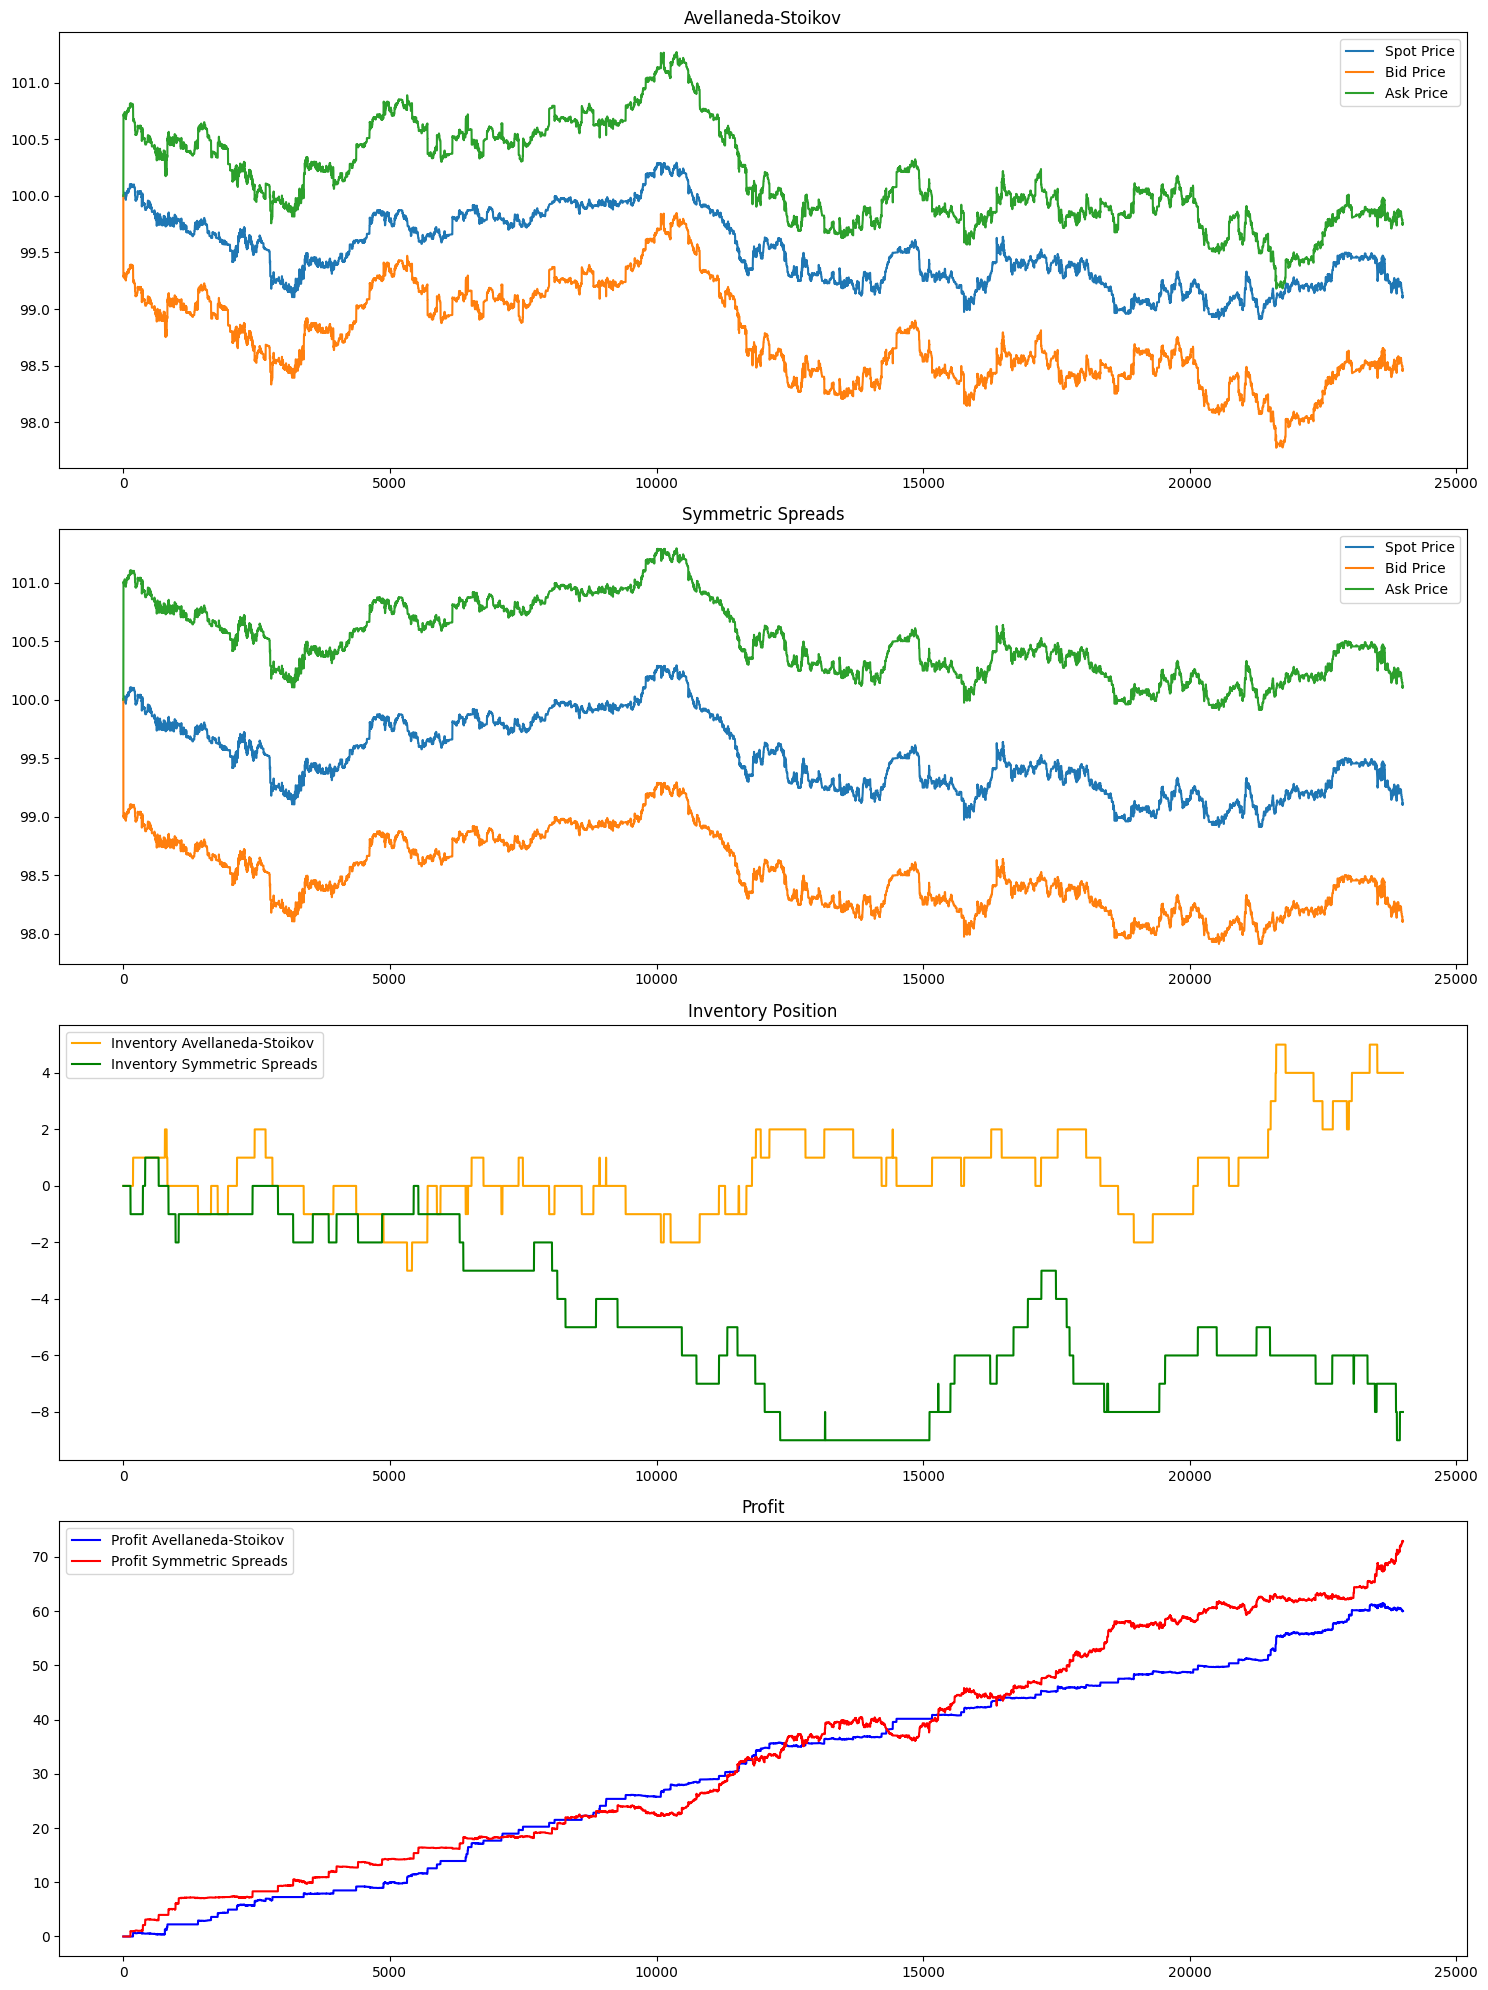

---------STATS--AS---------


Average Spread: 1.42

Max Spread: 1.43


Average Inventory held: 0.49

Maximum Inventory held (Short or Long): 5.00


Generated Profit: 59.99

Profit StDev: 17.94


Sharpe Ratio: 3.34

---------STATS--Sym--------


Average Inventory held: -4.79

Maximum Inventory held (Short or Long): 9.00


Generated Profit: 72.87

Profit StDev: 19.87


Sharpe Ratio: 3.67


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="b")
sym_bot = Symm(spread=0.02*s0)

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
bids_sym = np.zeros(M1+1)
asks_sym = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
q_sym = np.zeros(M1+1)
cash = np.zeros(M1+1)
cash_sym = np.zeros(M1+1)
profit = np.zeros(M1+1)
profit_sym = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
bids_sym[0] = s0
asks_sym[0] = s0
q[0] = 0
q_sym[0] = 0
cash[0] = 0
cash_sym[0] = 0
profit[0] = 0
profit_sym[0] = 0

for t in range(1,M1+1):

    S[t] = df['Mid-Price'].iloc[t]
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    bids_sym[t], asks_sym[t] = sym_bot.bid_ask(mid_price=S[t])
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    # Avellaneda-Stoikov Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]
        
    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]
    
    # Symmetric Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids_sym[t],ask=asks_sym[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1] + 1
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t]

    elif not executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1] - 1
        cash_sym[t] = cash_sym[t - 1] + asks_sym[t]

    elif not executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1]

    elif executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t] + asks_sym[t]

    profit_sym[t] = cash_sym[t] + q_sym[t] * S[t]

plt.figure(figsize=(15, 20))

# Plot S, Bids, and Asks for Avellaneda-Stoikov

plt.subplot(4, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Avellaneda-Stoikov')
plt.legend()

# Plot S, Bids, and Asks for Symmetric spreads

plt.subplot(4, 1, 2)
plt.plot(S, label='Spot Price')
plt.plot(bids_sym, label='Bid Price')
plt.plot(asks_sym, label='Ask Price')
plt.title('Symmetric Spreads')
plt.legend()

# Plot q for both strategies

plt.subplot(4, 1, 3)
plt.plot(q, label='Inventory Avellaneda-Stoikov', color='orange')
plt.plot(q_sym, label='Inventory Symmetric Spreads', color='green')
plt.title('Inventory Position')
plt.legend()

# Plot profit for both strategies

plt.subplot(4, 1, 4)
plt.plot(profit, label='Profit Avellaneda-Stoikov', color='blue')
plt.plot(profit_sym, label='Profit Symmetric Spreads', color='red')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--AS---------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}\n')
print(f'\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

print('\n---------STATS--Sym--------\n\n')


q_series = pd.Series(q_sym)

print(f'Average Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit_sym[-1]:.2f}\n')
print(f'Profit StDev: {profit_sym.std():.2f}\n')
print(f'\nSharpe Ratio: {profit_sym[-1]/profit_sym.std():.2f}')

#### **The Avellaneda-Stoikov Model Implementation when there is a risk limit and a drift ($bu$)**

This is an extension of the modified Avellaneda-Stoikov model proposed by Guéant et al. (2012), which extends the results to the case in which, apart from the inventory risk limit, the process of stock prices also has a drift. The most important aspects are the following:

1. Let $(\Omega, \mathcal{F}, \mathbb{P})$ be the probability space where all variables are defined and $(\mathcal{F})_{t \geq 0}$ to be a filtration with the usual conditions. The stock prices $S$ evolves respecting the diffusion process $$dS_t = \mu dt + \sigma dW_t$$ where $W$ is a brownian motion, $\mu$ is the drift or trend and $\sigma$ is the volatility parameter for the prices.

2. The inventory of the market-maker is $$q_t=N^{b}_t-N^{a}_t$$ where $N^b$ and $N^{a}$ are the point processes independent of $(W_t)_{t \geq 0}$ which give the number of bought and sold assets, respectively.

3. Arrival rates of these processes depend on $S_t^{a}$ and $S_t^{b}$ and intensities $\lambda^{a}$ and $\lambda^{b}$ associted respectively with $N^{a}$ and $N^{b}$ depend on the difference between quoted and midpoint prices $\delta^{a}=S_t^{a}-S_t$ and $\delta^{b}=S_t-S_t^{b}$ with the form
$$
\lambda^{i} (\delta^{i}) = A\exp{(-k \delta^{i})}\quad\text{for }i\in\{1,2\}
$$

4. The cash of the market-maker evolves according to $$dX_t = (S_t+\delta^{a})dN^{a}_t-(S_t-\delta^{b})dN^{b}_t$$ where $X$ is the amount of cash.

5. There is a bound $Q$ for the inventory that a market-maker is authorized to have (he has a risk limit).

6. The agent's objective function is the CARA utility function $v(x,s,q)=E_t[-\exp(-\gamma(x_T+ q_T s_T))]$, so that the optimization problem is $$\sup_{(\delta^{a}_t)_t,(\delta^{b}_t)_t \in \mathcal{A}}{E_t[-\exp(-\gamma(x_T+ q_T s_T))]}$$ where $\mathcal{A}$ is the set of predictable processes bounded from below and $\gamma$ is the risk aversion coefficient.

The numerical simulation results of this model are summarized below:

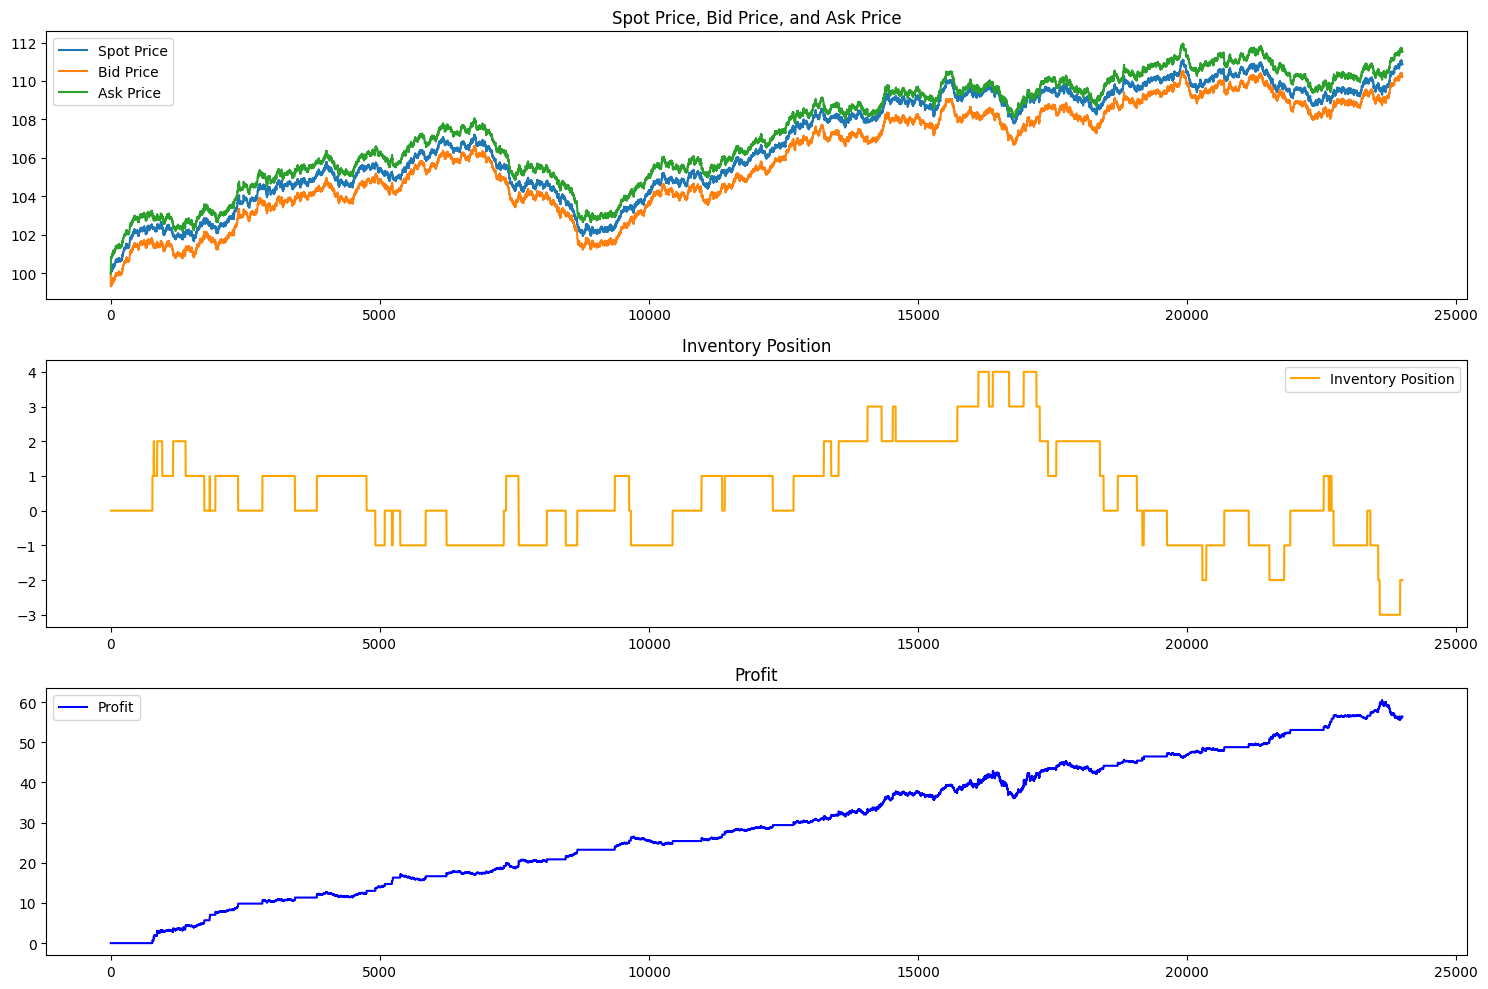

---------STATS--------


Average Spread: 1.42

Max Spread: 1.43


Average Inventory held: 0.47

Maximum Inventory held (Short or Long): 4.00


Generated Profit: 56.32

Profit StDev: 16.00


Sharpe Ratio: 3.52


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bu")

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
cash = np.zeros(M1+1)
profit = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
q[0] = 0
cash[0] = 0
profit[0] = 0

for t in range(1,M1+1):

    z = np.random.randn()
    S[t] = S[t-1] + mu1*(T1/M1) + sigma1*math.sqrt((T1/M1))*z
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    executed_buy, executed_sell = sim_trad(S=S[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Spot Price, Bid Price, and Ask Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(q, label='Inventory Position', color='orange')
plt.title('Inventory Position')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(profit, label='Profit', color='blue')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}')
print(f'\n\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

We can now do backtesting with the two bots and using a cryptocurrency pair such as BTC/USDT, one of the most important ones. The results are the following:

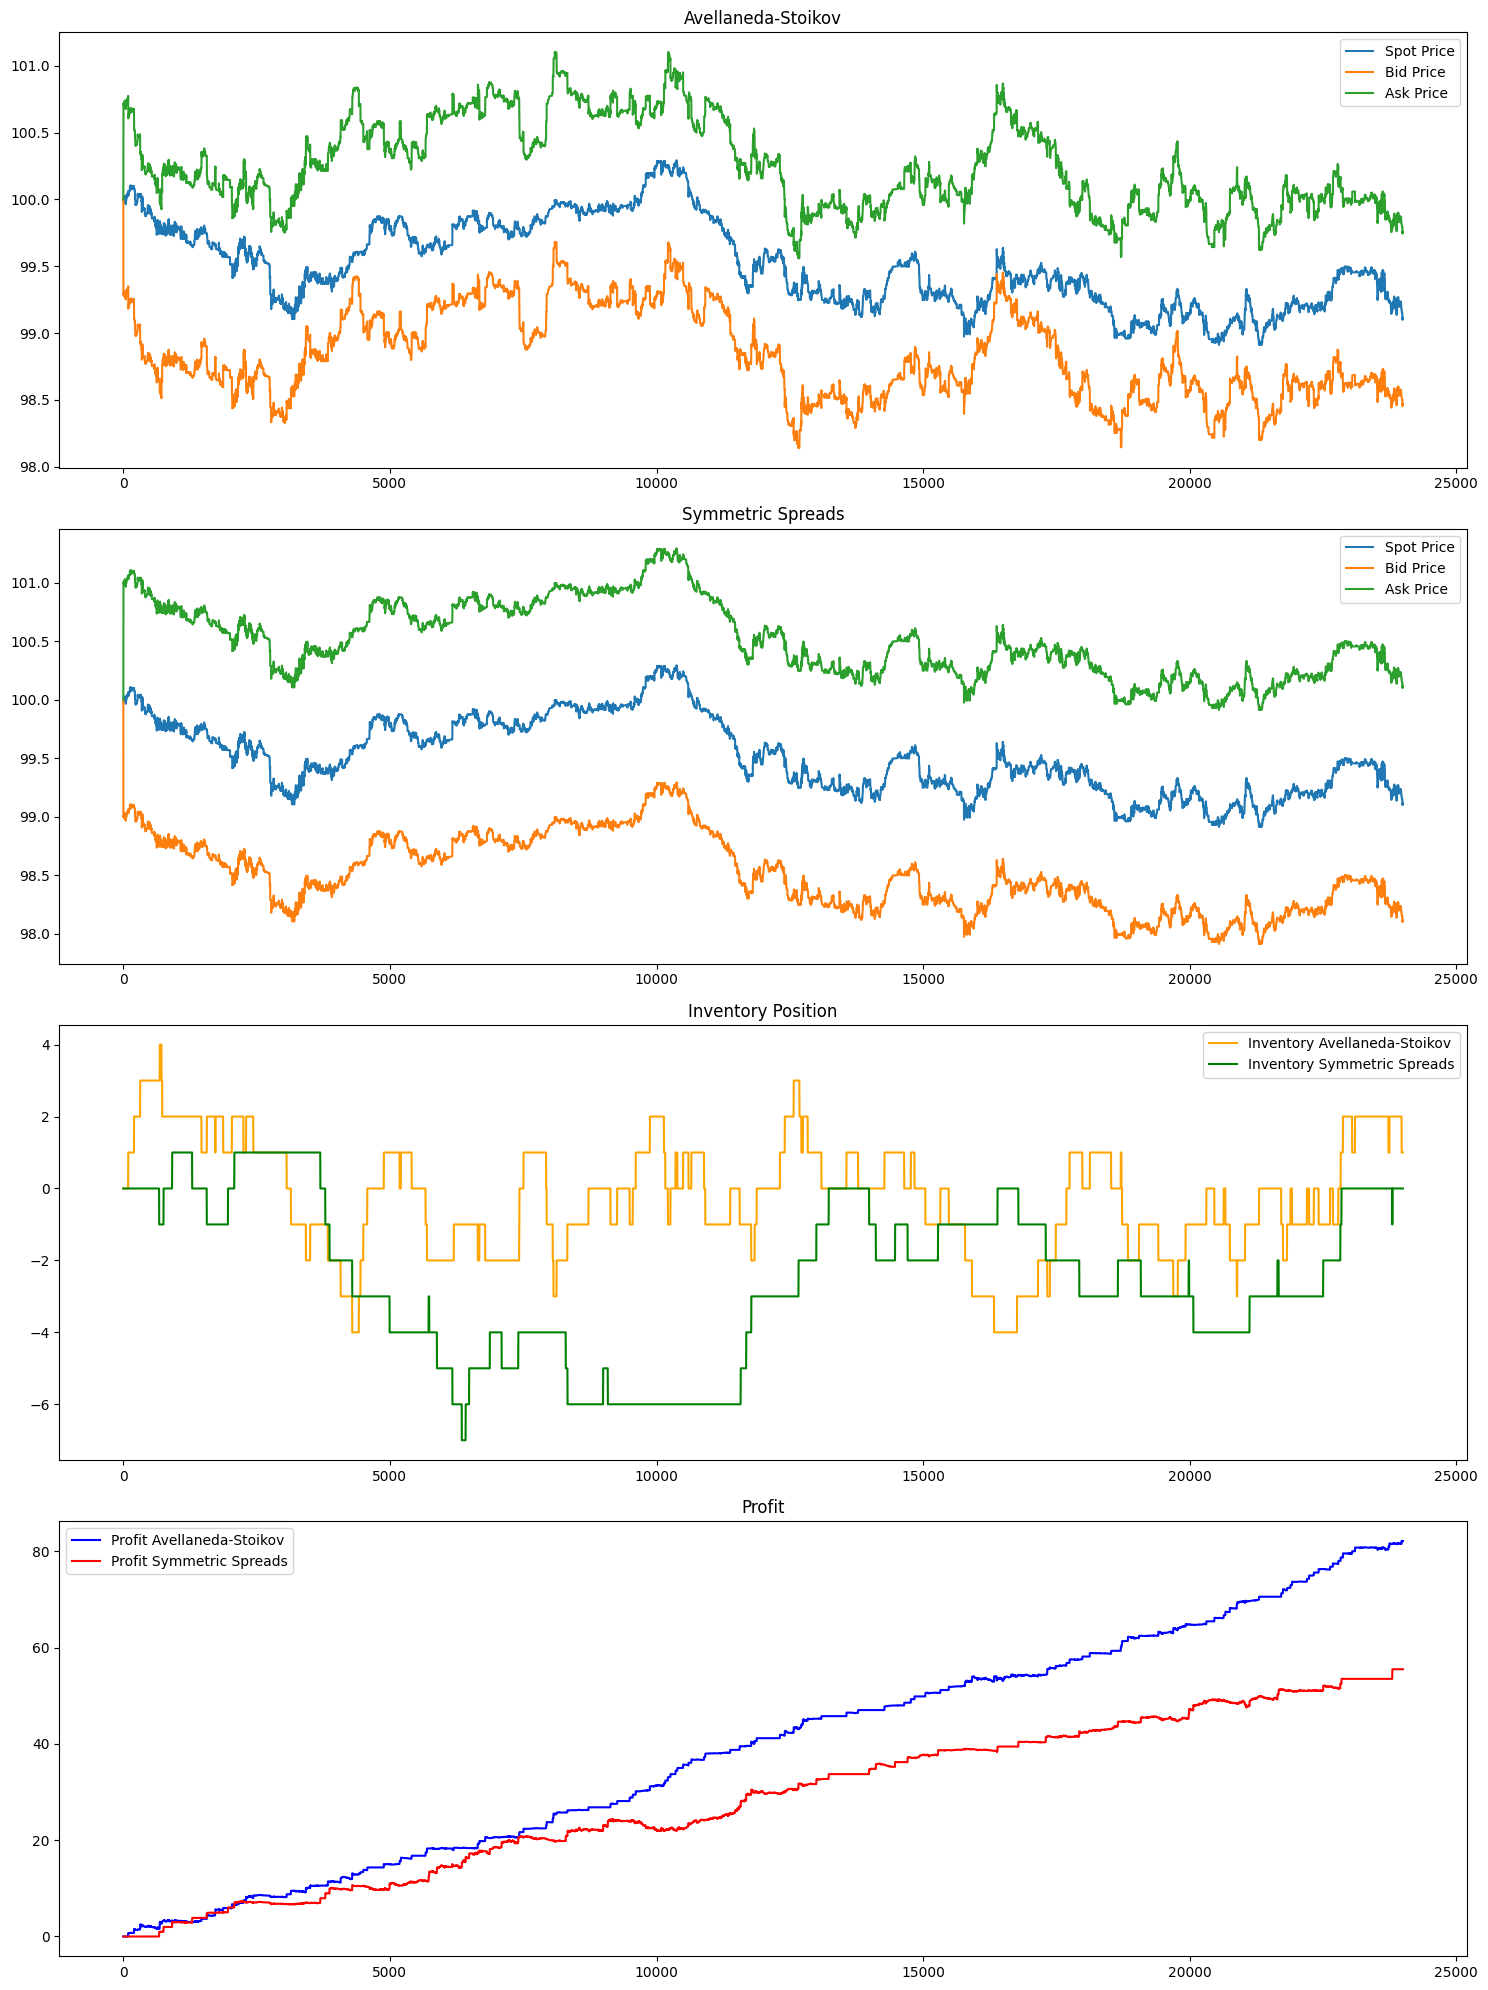

---------STATS--AS---------


Average Spread: 1.42

Max Spread: 1.43


Average Inventory held: -0.25

Maximum Inventory held (Short or Long): 4.00


Generated Profit: 82.09

Profit StDev: 23.53


Sharpe Ratio: 3.49

---------STATS--Sym--------


Average Inventory held: -2.52

Maximum Inventory held (Short or Long): 7.00


Generated Profit: 55.50

Profit StDev: 16.14


Sharpe Ratio: 3.44


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bu")
sym_bot = Symm(spread=0.02*s0)

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
bids_sym = np.zeros(M1+1)
asks_sym = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
q_sym = np.zeros(M1+1)
cash = np.zeros(M1+1)
cash_sym = np.zeros(M1+1)
profit = np.zeros(M1+1)
profit_sym = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
bids_sym[0] = s0
asks_sym[0] = s0
q[0] = 0
q_sym[0] = 0
cash[0] = 0
cash_sym[0] = 0
profit[0] = 0
profit_sym[0] = 0

for t in range(1,M1+1):

    S[t] = df['Mid-Price'].iloc[t]
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    bids_sym[t], asks_sym[t] = sym_bot.bid_ask(mid_price=S[t])
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    # Avellaneda-Stoikov Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]
        
    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]
    
    # Symmetric Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids_sym[t],ask=asks_sym[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1] + 1
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t]

    elif not executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1] - 1
        cash_sym[t] = cash_sym[t - 1] + asks_sym[t]

    elif not executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1]

    elif executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t] + asks_sym[t]

    profit_sym[t] = cash_sym[t] + q_sym[t] * S[t]

plt.figure(figsize=(15, 20))

# Plot S, Bids, and Asks for Avellaneda-Stoikov

plt.subplot(4, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Avellaneda-Stoikov')
plt.legend()

# Plot S, Bids, and Asks for Symmetric spreads

plt.subplot(4, 1, 2)
plt.plot(S, label='Spot Price')
plt.plot(bids_sym, label='Bid Price')
plt.plot(asks_sym, label='Ask Price')
plt.title('Symmetric Spreads')
plt.legend()

# Plot q for both strategies

plt.subplot(4, 1, 3)
plt.plot(q, label='Inventory Avellaneda-Stoikov', color='orange')
plt.plot(q_sym, label='Inventory Symmetric Spreads', color='green')
plt.title('Inventory Position')
plt.legend()

# Plot profit for both strategies

plt.subplot(4, 1, 4)
plt.plot(profit, label='Profit Avellaneda-Stoikov', color='blue')
plt.plot(profit_sym, label='Profit Symmetric Spreads', color='red')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--AS---------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}\n')
print(f'\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

print('\n---------STATS--Sym--------\n\n')


q_series = pd.Series(q_sym)

print(f'Average Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit_sym[-1]:.2f}\n')
print(f'Profit StDev: {profit_sym.std():.2f}\n')
print(f'\nSharpe Ratio: {profit_sym[-1]/profit_sym.std():.2f}')

#### **The Avellaneda-Stoikov Model Implementation when there is a risk limit and a jump process ($bj$)**

This is an extension of the modified Avellaneda-Stoikov model proposed by Guéant et al. (2012), which extends the results to the case in which, apart from the inventory risk limit, the process of stock prices includes jumps. The most important aspects are the following:

1. Let $(\Omega, \mathcal{F}, \mathbb{P})$ be the probability space where all variables are defined and $(\mathcal{F})_{t \geq 0}$ to be a filtration with the usual conditions. The stock prices $S$ evolves respecting the diffusion process $$dS_t = \sigma dW_t + \xi(dN_t^{a}-dN_t^{b})\quad\text{for }\text{ }\xi>0$$ where $W$ is a brownian motion, $\mu$ is the drift or trend and $\sigma$ is the volatility parameter for the prices.

2. The inventory of the market-maker is $$q_t=N^{b}_t-N^{a}_t$$ where $N^b$ and $N^{a}$ are the point processes independent of $(W_t)_{t \geq 0}$ which give the number of bought and sold assets, respectively.

3. Arrival rates of these processes depend on $S_t^{a}$ and $S_t^{b}$ and intensities $\lambda^{a}$ and $\lambda^{b}$ associted respectively with $N^{a}$ and $N^{b}$ depend on the difference between quoted and midpoint prices $\delta^{a}=S_t^{a}-S_t$ and $\delta^{b}=S_t-S_t^{b}$ with the form
$$
\lambda^{i} (\delta^{i}) = A\exp{(-k \delta^{i})}\quad\text{for }i\in\{1,2\}
$$

4. The cash of the market-maker evolves according to $$dX_t = (S_t+\delta^{a})dN^{a}_t-(S_t-\delta^{b})dN^{b}_t$$ where $X$ is the amount of cash.

5. There is a bound $Q$ for the inventory that a market-maker is authorized to have (he has a risk limit).

6. The agent's objective function is the CARA utility function $v(x,s,q)=E_t[-\exp(-\gamma(x_T+ q_T s_T))]$, so that the optimization problem is $$\sup_{(\delta^{a}_t)_t,(\delta^{b}_t)_t \in \mathcal{A}}{E_t[-\exp(-\gamma(x_T+ q_T s_T))]}$$ where $\mathcal{A}$ is the set of predictable processes bounded from below and $\gamma$ is the risk aversion coefficient.

The numerical simulation results of this model are summarized below:

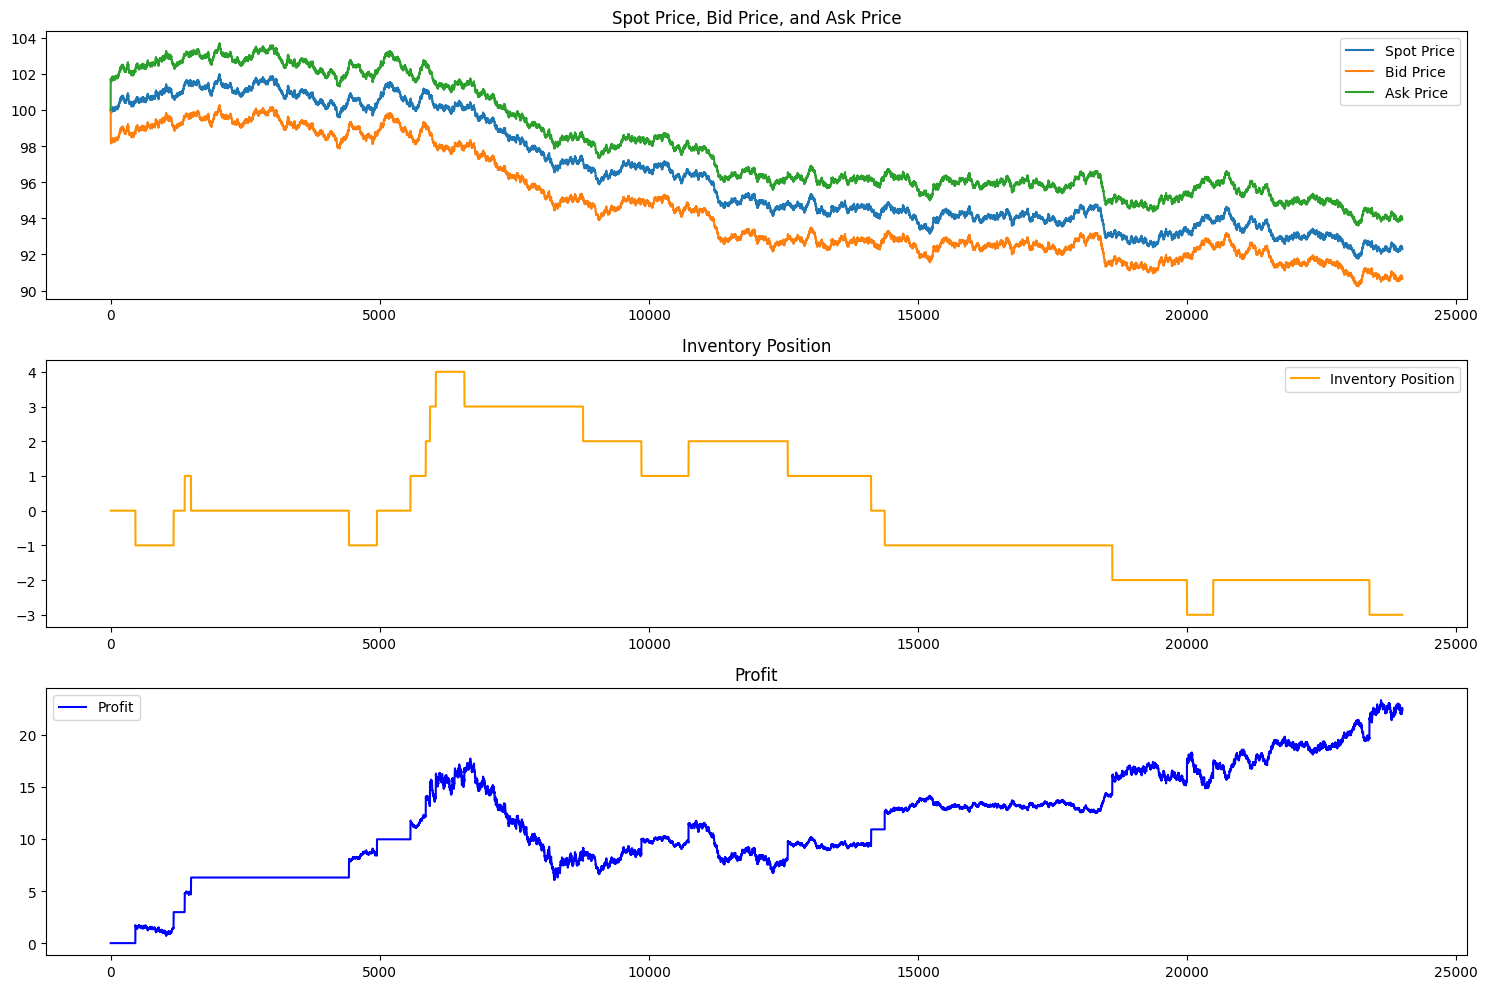

---------STATS--------


Average Spread: 3.42

Max Spread: 3.43


Average Inventory held: 0.02

Maximum Inventory held (Short or Long): 4.00


Generated Profit: 22.49

Profit StDev: 4.96


Sharpe Ratio: 4.53


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bj")

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
cash = np.zeros(M1+1)
profit = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
q[0] = 0
cash[0] = 0
profit[0] = 0

for t in range(1,M1+1):

    z = np.random.randn()

    if np.random.rand() < random.expovariate(A1*math.exp(-k1*(asks[t-1]-S[t-1]))):
        dNa = 1
    else:
        dNa = 0
    
    if np.random.rand() < random.expovariate(A1*math.exp(-k1*(S[t-1]-bids[t-1]))):
        dNb = 1
    else:
        dNb = 0

    S[t] = S[t-1] + sigma1*math.sqrt((T1/M1))*z + eps1*(dNa-dNb)*(T1/M1)
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    executed_buy, executed_sell = sim_trad(S=S[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Spot Price, Bid Price, and Ask Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(q, label='Inventory Position', color='orange')
plt.title('Inventory Position')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(profit, label='Profit', color='blue')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}')
print(f'\n\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

We can now do backtesting with the two bots and using a cryptocurrency pair such as BTC/USDT, one of the most important ones. The results are the following:

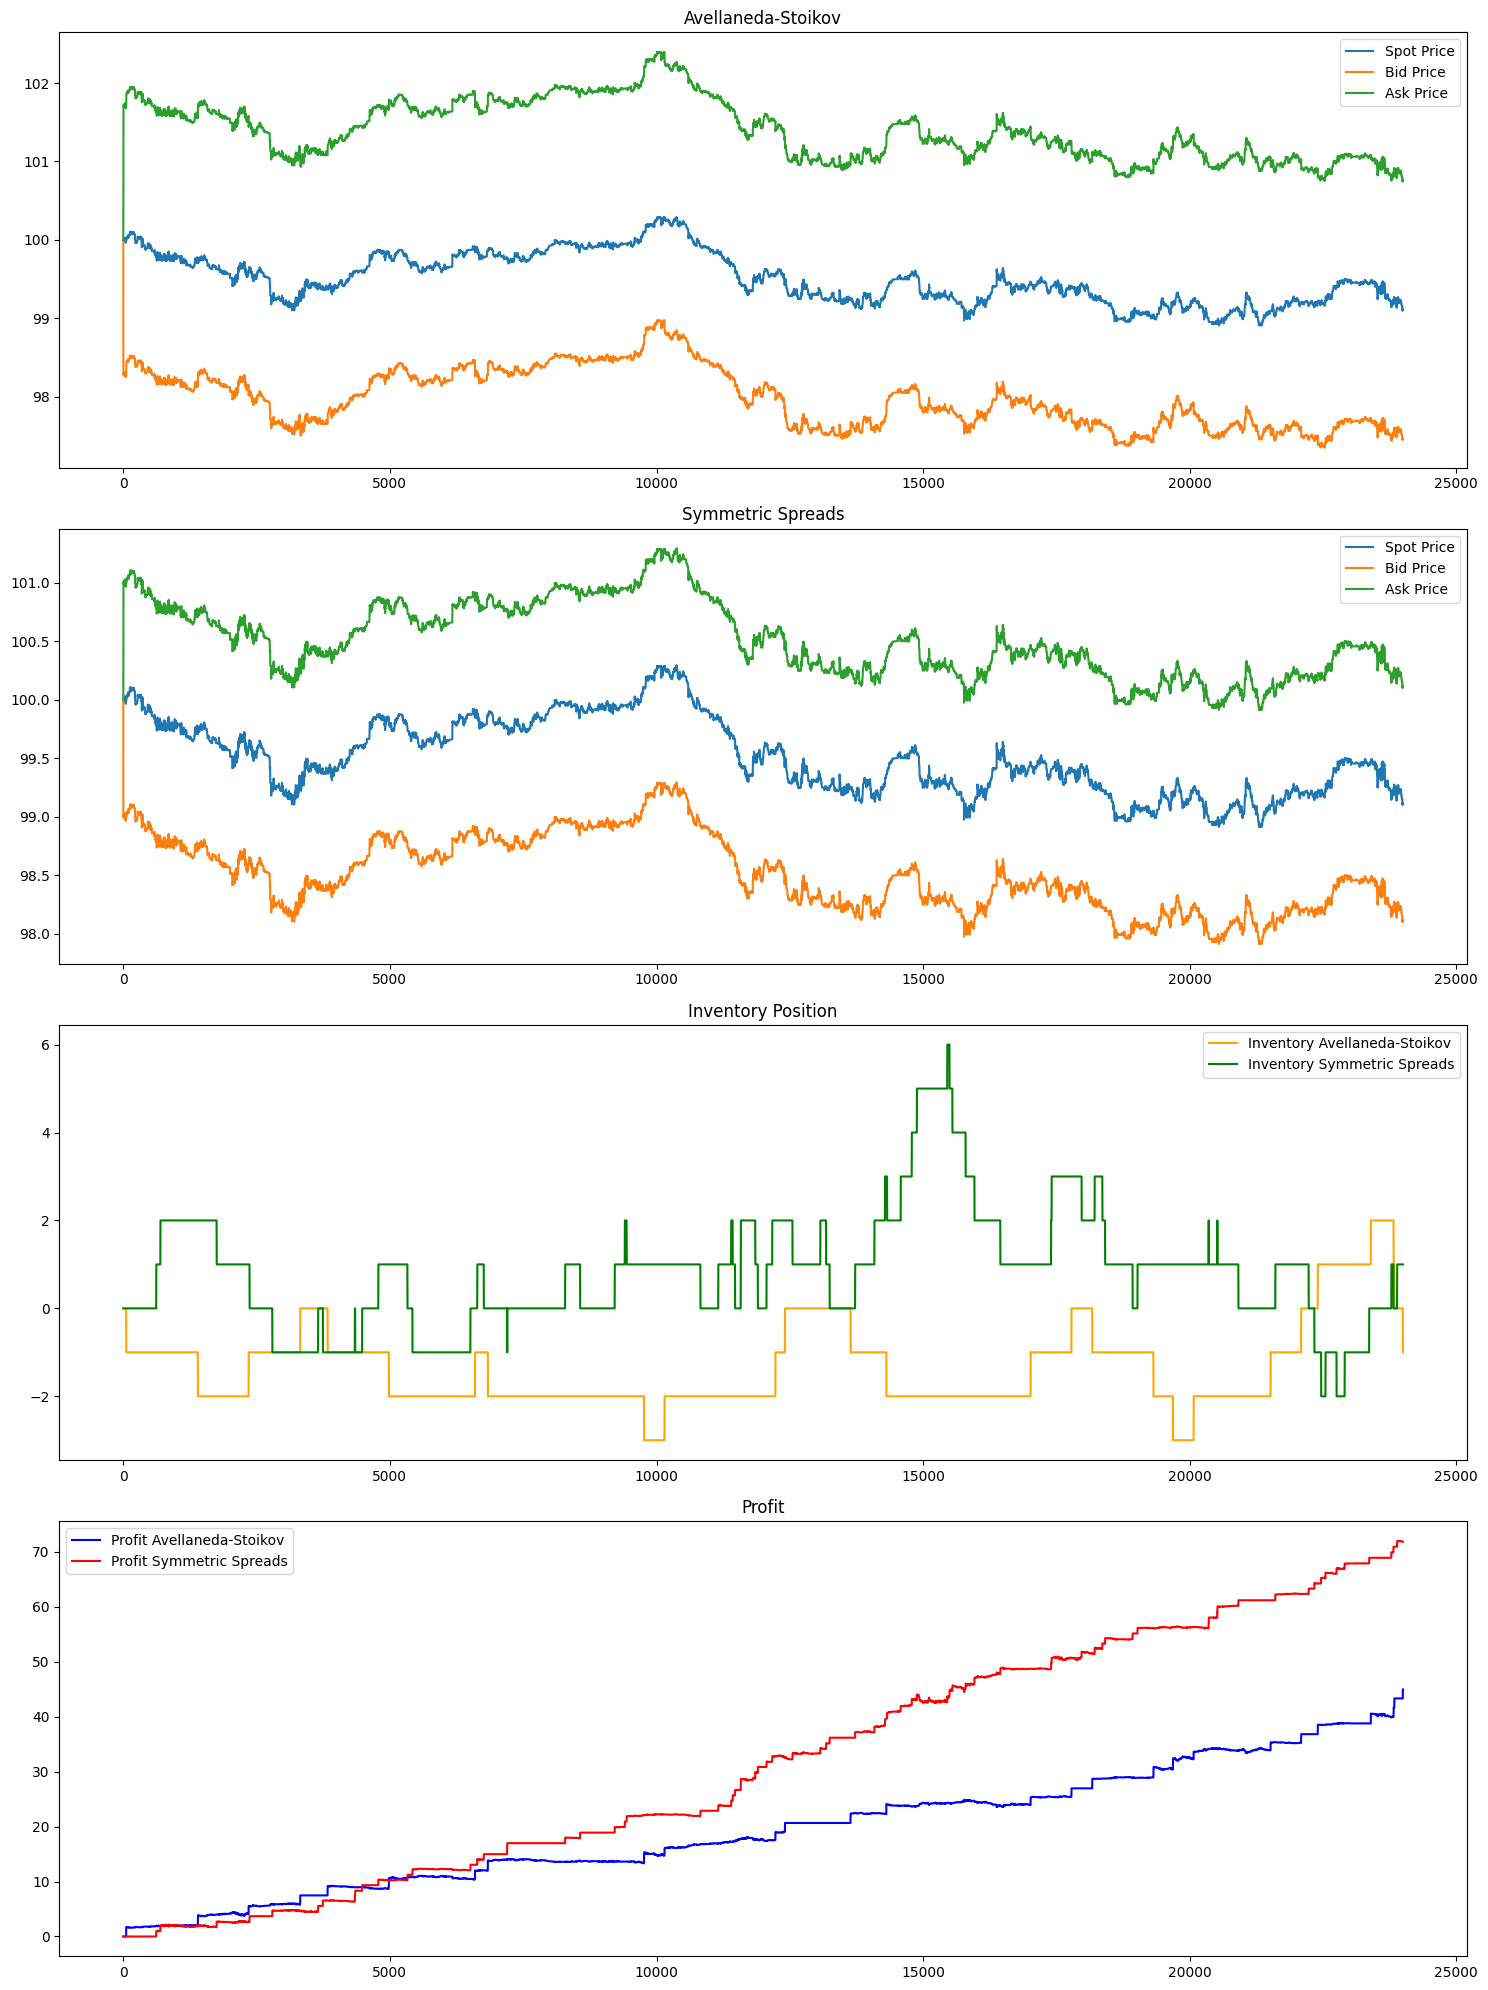

---------STATS--AS---------


Average Spread: 3.42

Max Spread: 3.43


Average Inventory held: -1.32

Maximum Inventory held (Short or Long): 3.00


Generated Profit: 44.97

Profit StDev: 10.84


Sharpe Ratio: 4.15

---------STATS--Sym--------


Average Inventory held: 0.80

Maximum Inventory held (Short or Long): 6.00


Generated Profit: 71.83

Profit StDev: 21.75


Sharpe Ratio: 3.30


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bj")
sym_bot = Symm(spread=0.02*s0)

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
bids_sym = np.zeros(M1+1)
asks_sym = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
q_sym = np.zeros(M1+1)
cash = np.zeros(M1+1)
cash_sym = np.zeros(M1+1)
profit = np.zeros(M1+1)
profit_sym = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
bids_sym[0] = s0
asks_sym[0] = s0
q[0] = 0
q_sym[0] = 0
cash[0] = 0
cash_sym[0] = 0
profit[0] = 0
profit_sym[0] = 0

for t in range(1,M1+1):

    S[t] = df['Mid-Price'].iloc[t]
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    bids_sym[t], asks_sym[t] = sym_bot.bid_ask(mid_price=S[t])
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    # Avellaneda-Stoikov Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]
        
    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]
    
    # Symmetric Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids_sym[t],ask=asks_sym[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1] + 1
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t]

    elif not executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1] - 1
        cash_sym[t] = cash_sym[t - 1] + asks_sym[t]

    elif not executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1]

    elif executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t] + asks_sym[t]

    profit_sym[t] = cash_sym[t] + q_sym[t] * S[t]

plt.figure(figsize=(15, 20))

# Plot S, Bids, and Asks for Avellaneda-Stoikov

plt.subplot(4, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Avellaneda-Stoikov')
plt.legend()

# Plot S, Bids, and Asks for Symmetric spreads

plt.subplot(4, 1, 2)
plt.plot(S, label='Spot Price')
plt.plot(bids_sym, label='Bid Price')
plt.plot(asks_sym, label='Ask Price')
plt.title('Symmetric Spreads')
plt.legend()

# Plot q for both strategies

plt.subplot(4, 1, 3)
plt.plot(q, label='Inventory Avellaneda-Stoikov', color='orange')
plt.plot(q_sym, label='Inventory Symmetric Spreads', color='green')
plt.title('Inventory Position')
plt.legend()

# Plot profit for both strategies

plt.subplot(4, 1, 4)
plt.plot(profit, label='Profit Avellaneda-Stoikov', color='blue')
plt.plot(profit_sym, label='Profit Symmetric Spreads', color='red')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--AS---------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}\n')
print(f'\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

print('\n---------STATS--Sym--------\n\n')


q_series = pd.Series(q_sym)

print(f'Average Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit_sym[-1]:.2f}\n')
print(f'Profit StDev: {profit_sym.std():.2f}\n')
print(f'\nSharpe Ratio: {profit_sym[-1]/profit_sym.std():.2f}')

#### **The Avellaneda-Stoikov Model Implementation when there is a risk limit and an infinite trading horizon ($bi$)**

This is the modified Avellaneda-Stoikov model proposed by Guéant et al. (2012), which extends the results from the original paper to include a risk limitation for the inventory and an infinite trading horizon. All the aspects are equal to the finite trading horizon case (model $b$), but now the authors compute the limit for $\delta^{b}$ and $\delta^{a}$ and provide a suitable closed-form approximation.

For $\delta^{b}$ and $\delta^{a}$, the limits when $T \rightarrow \infty$ are
$$
\lim_{T\rightarrow \infty} \delta^{b} = \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{1}{k}\ln\left(\frac{\mathcal{f}^0_q}{\mathcal{f}^0_{q+1}}\right)
$$
$$
\lim_{T\rightarrow \infty} \delta^{a} = \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{1}{k}\ln\left(\frac{\mathcal{f}^0_q}{\mathcal{f}^0_{q-1}}\right)
$$

where $\mathcal{f}^0$ is an eigenvector corresponding to the smallest eigenvalue of the matrix

$$
\begin{pmatrix}
\alpha Q^2  & -\eta & 0 & \cdots & \cdots & 0 & 0 \\
-\eta & \alpha (Q-1)^2 & - \eta & \cdots & \cdots & \vdots & \vdots \\
0 & -\eta & \alpha (Q-2)^2 & \cdots & \ddots & \vdots & \vdots \\
\vdots & 0 & -\eta & \ddots & \ddots & - \eta & \vdots \\
\vdots & \vdots & 0 & \cdots & -\eta & \alpha (Q-1)^2 & -\eta \\
\vdots & \vdots & \vdots & \cdots & 0 & -\eta & \alpha Q^2
\end{pmatrix}
$$

Because it is cumbersome to find a closed-form representation for $\mathcal{f}^0$, the authors offer a closed-form approximation for both results which simplify the usage of the bid and ask prices distances for optimal trading:
$$
\lim_{T\rightarrow \infty} \delta^{b} \approx \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{2q+1}{2}\sqrt{\frac{\sigma^2 \gamma}{2kA}\left(1+\frac{\gamma}{k}\right)^{1+k/\gamma}}
$$
$$
\lim_{T\rightarrow \infty} \delta^{a} \approx \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)-\frac{2q-1}{2}\sqrt{\frac{\sigma^2 \gamma}{2kA}\left(1+\frac{\gamma}{k}\right)^{1+k/\gamma}}
$$

The numerical simulation results of this model are summarized below:

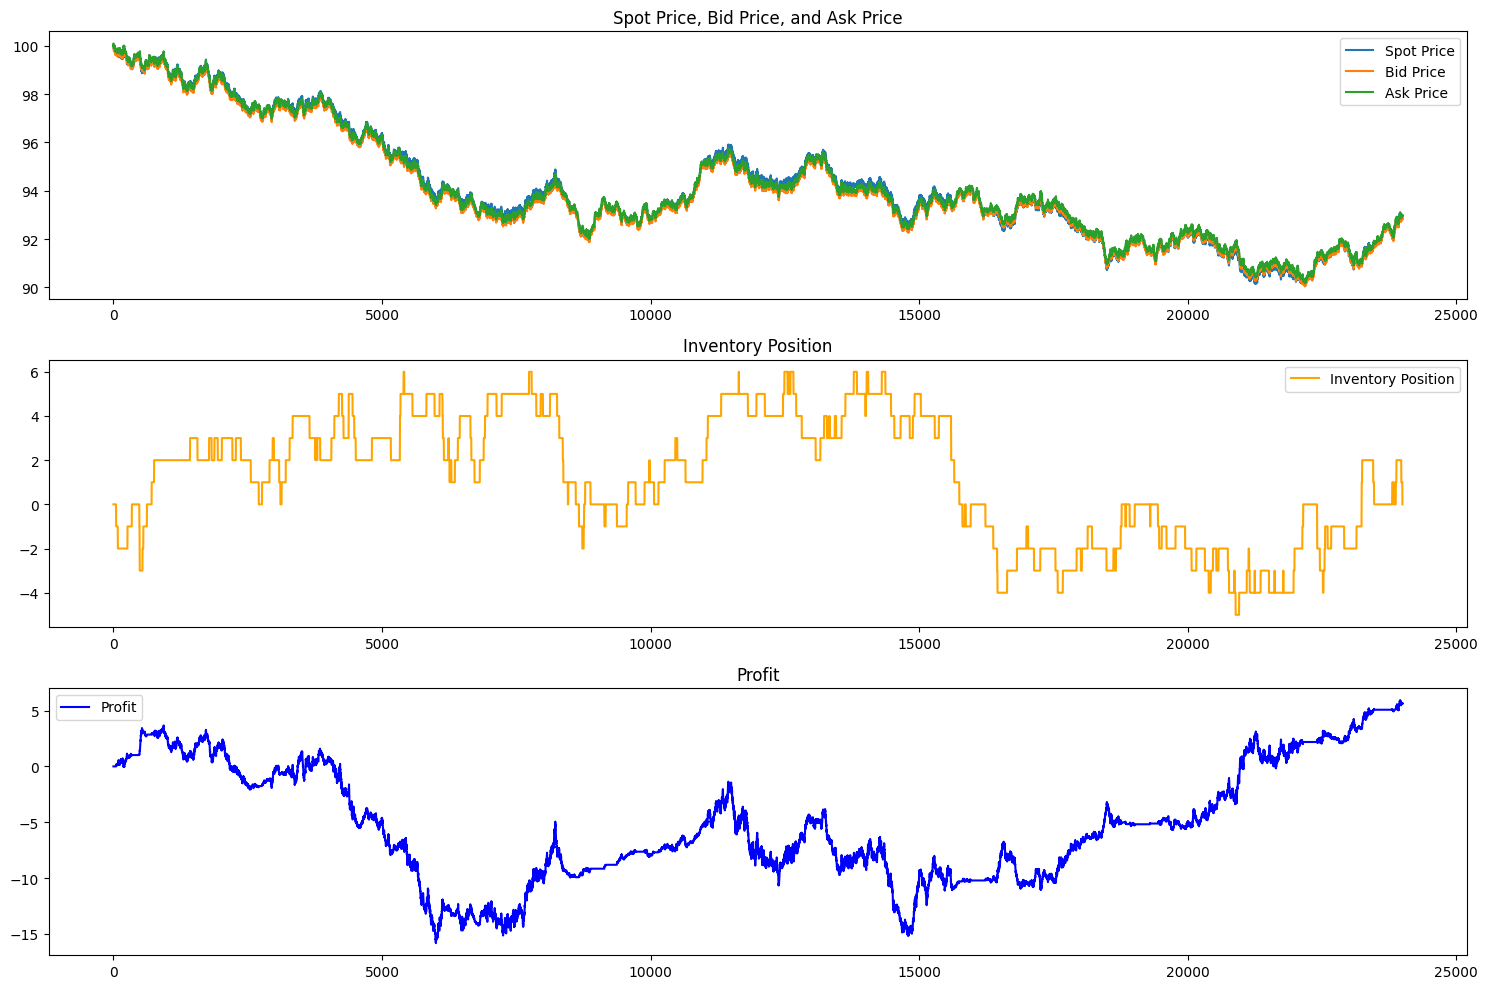

---------STATS--------


Average Spread: 0.14

Max Spread: 0.14


Average Inventory held: 1.22

Maximum Inventory held (Short or Long): 6.00


Generated Profit: 5.63

Profit StDev: 5.19


Sharpe Ratio: 1.08


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bi")

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
cash = np.zeros(M1+1)
profit = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
q[0] = 0
cash[0] = 0
profit[0] = 0

for t in range(1,M1+1):

    z = np.random.randn()
    S[t] = S[t-1] + sigma1*math.sqrt((T1/M1))*z
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    executed_buy, executed_sell = sim_trad(S=S[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Spot Price, Bid Price, and Ask Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(q, label='Inventory Position', color='orange')
plt.title('Inventory Position')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(profit, label='Profit', color='blue')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}')
print(f'\n\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

We can now do backtesting with the two bots and using a cryptocurrency pair such as BTC/USDT, one of the most important ones. The results are the following:

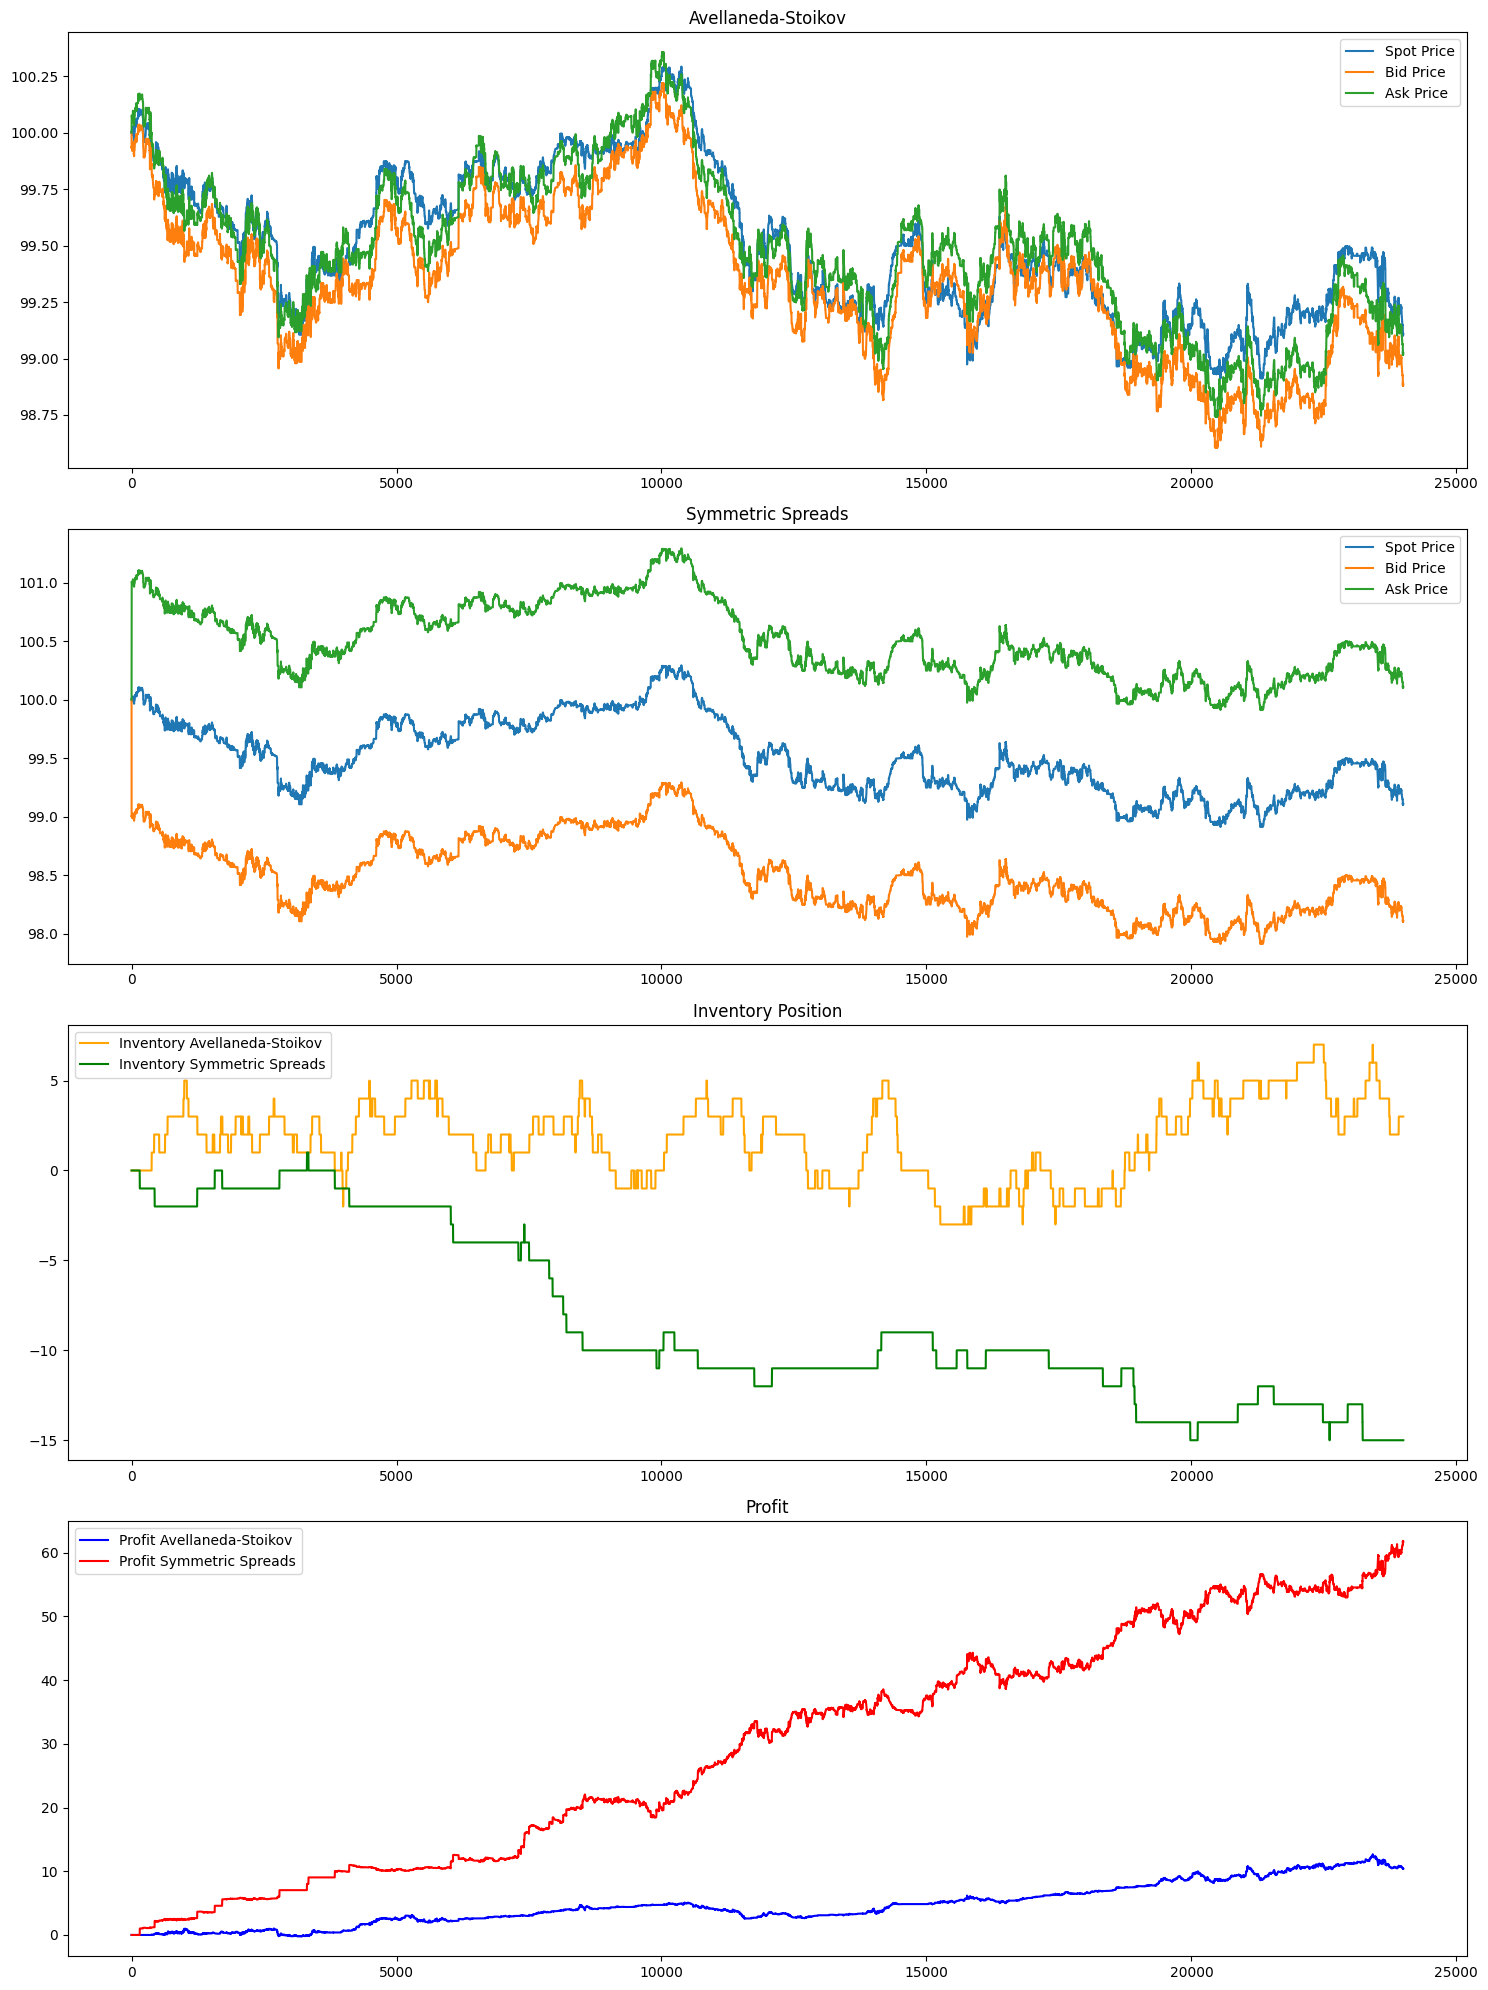

---------STATS--AS---------


Average Spread: 0.14

Max Spread: 0.14


Average Inventory held: 1.71

Maximum Inventory held (Short or Long): 7.00


Generated Profit: 10.40

Profit StDev: 3.27


Sharpe Ratio: 3.18

---------STATS--Sym--------


Average Inventory held: -8.31

Maximum Inventory held (Short or Long): 15.00


Generated Profit: 61.72

Profit StDev: 17.87


Sharpe Ratio: 3.45


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bi")
sym_bot = Symm(spread=0.02*s0)

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
bids_sym = np.zeros(M1+1)
asks_sym = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
q_sym = np.zeros(M1+1)
cash = np.zeros(M1+1)
cash_sym = np.zeros(M1+1)
profit = np.zeros(M1+1)
profit_sym = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
bids_sym[0] = s0
asks_sym[0] = s0
q[0] = 0
q_sym[0] = 0
cash[0] = 0
cash_sym[0] = 0
profit[0] = 0
profit_sym[0] = 0

for t in range(1,M1+1):

    S[t] = df['Mid-Price'].iloc[t]
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    bids_sym[t], asks_sym[t] = sym_bot.bid_ask(mid_price=S[t])
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    # Avellaneda-Stoikov Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]
        
    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]
    
    # Symmetric Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids_sym[t],ask=asks_sym[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1] + 1
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t]

    elif not executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1] - 1
        cash_sym[t] = cash_sym[t - 1] + asks_sym[t]

    elif not executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1]

    elif executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t] + asks_sym[t]

    profit_sym[t] = cash_sym[t] + q_sym[t] * S[t]

plt.figure(figsize=(15, 20))

# Plot S, Bids, and Asks for Avellaneda-Stoikov

plt.subplot(4, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Avellaneda-Stoikov')
plt.legend()

# Plot S, Bids, and Asks for Symmetric spreads

plt.subplot(4, 1, 2)
plt.plot(S, label='Spot Price')
plt.plot(bids_sym, label='Bid Price')
plt.plot(asks_sym, label='Ask Price')
plt.title('Symmetric Spreads')
plt.legend()

# Plot q for both strategies

plt.subplot(4, 1, 3)
plt.plot(q, label='Inventory Avellaneda-Stoikov', color='orange')
plt.plot(q_sym, label='Inventory Symmetric Spreads', color='green')
plt.title('Inventory Position')
plt.legend()

# Plot profit for both strategies

plt.subplot(4, 1, 4)
plt.plot(profit, label='Profit Avellaneda-Stoikov', color='blue')
plt.plot(profit_sym, label='Profit Symmetric Spreads', color='red')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--AS---------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}\n')
print(f'\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

print('\n---------STATS--Sym--------\n\n')


q_series = pd.Series(q_sym)

print(f'Average Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit_sym[-1]:.2f}\n')
print(f'Profit StDev: {profit_sym.std():.2f}\n')
print(f'\nSharpe Ratio: {profit_sym[-1]/profit_sym.std():.2f}')

#### **The Avellaneda-Stoikov Model Implementation when there is a risk limit, a drift and an infinite trading horizon ($biu$)**

This is the modified Avellaneda-Stoikov model proposed by Guéant et al. (2012), which extends the results from the original paper to include a risk limitation for the inventory and a drift to the stock price process when there is an infinite trading horizon. All the aspects are equal to the finite trading horizon case with drift (model $bu$), but now the authors compute the limit for $\delta^{b}$ and $\delta^{a}$ and provide a suitable closed-form approximation.

For $\delta^{b}$ and $\delta^{a}$, the limits when $T \rightarrow \infty$ are
$$
\lim_{T\rightarrow \infty} \delta^{b} = \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{1}{k}\ln\left(\frac{\mathcal{f}^0_q}{\mathcal{f}^0_{q+1}}\right)
$$
$$
\lim_{T\rightarrow \infty} \delta^{a} = \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{1}{k}\ln\left(\frac{\mathcal{f}^0_q}{\mathcal{f}^0_{q-1}}\right)
$$

where $\mathcal{f}^0$ is an eigenvector corresponding to the smallest eigenvalue of the matrix

$$
\begin{pmatrix}
\alpha Q^2 -\beta Q & -\eta & 0 & \cdots & \cdots & 0 & 0 \\
-\eta & \alpha (Q-1)^2 - \beta (Q-1) & - \eta & \cdots & \cdots & \vdots & \vdots \\
0 & -\eta & \alpha (Q-2)^2 - \beta (Q-2)& \cdots & \ddots & \vdots & \vdots \\
\vdots & 0 & -\eta & \ddots & \ddots & - \eta & \vdots \\
\vdots & \vdots & 0 & \cdots & -\eta & \alpha (Q-1)^2 - \beta(Q-1) & -\eta \\
\vdots & \vdots & \vdots & \cdots & 0 & -\eta & \alpha Q^2-\beta Q
\end{pmatrix}
$$

Because it is cumbersome to find a closed-form representation for $\mathcal{f}^0$, the authors offer a closed-form approximation for both results which simplify the usage of the bid and ask prices distances for optimal trading:
$$
\lim_{T\rightarrow \infty} \delta^{b} \approx \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\left[-\frac{\mu}{\gamma \sigma^2}+\frac{2q+1}{2}  \right]\sqrt{\frac{\sigma^2 \gamma}{2kA}\left(1+\frac{\gamma}{k}\right)^{1+k/\gamma}}
$$
$$
\lim_{T\rightarrow \infty} \delta^{a} \approx \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\left[\frac{\mu}{\gamma \sigma^2}-\frac{2q-1}{2}  \right]\sqrt{\frac{\sigma^2 \gamma}{2kA}\left(1+\frac{\gamma}{k}\right)^{1+k/\gamma}}
$$

The numerical simulation results of this model are summarized below:

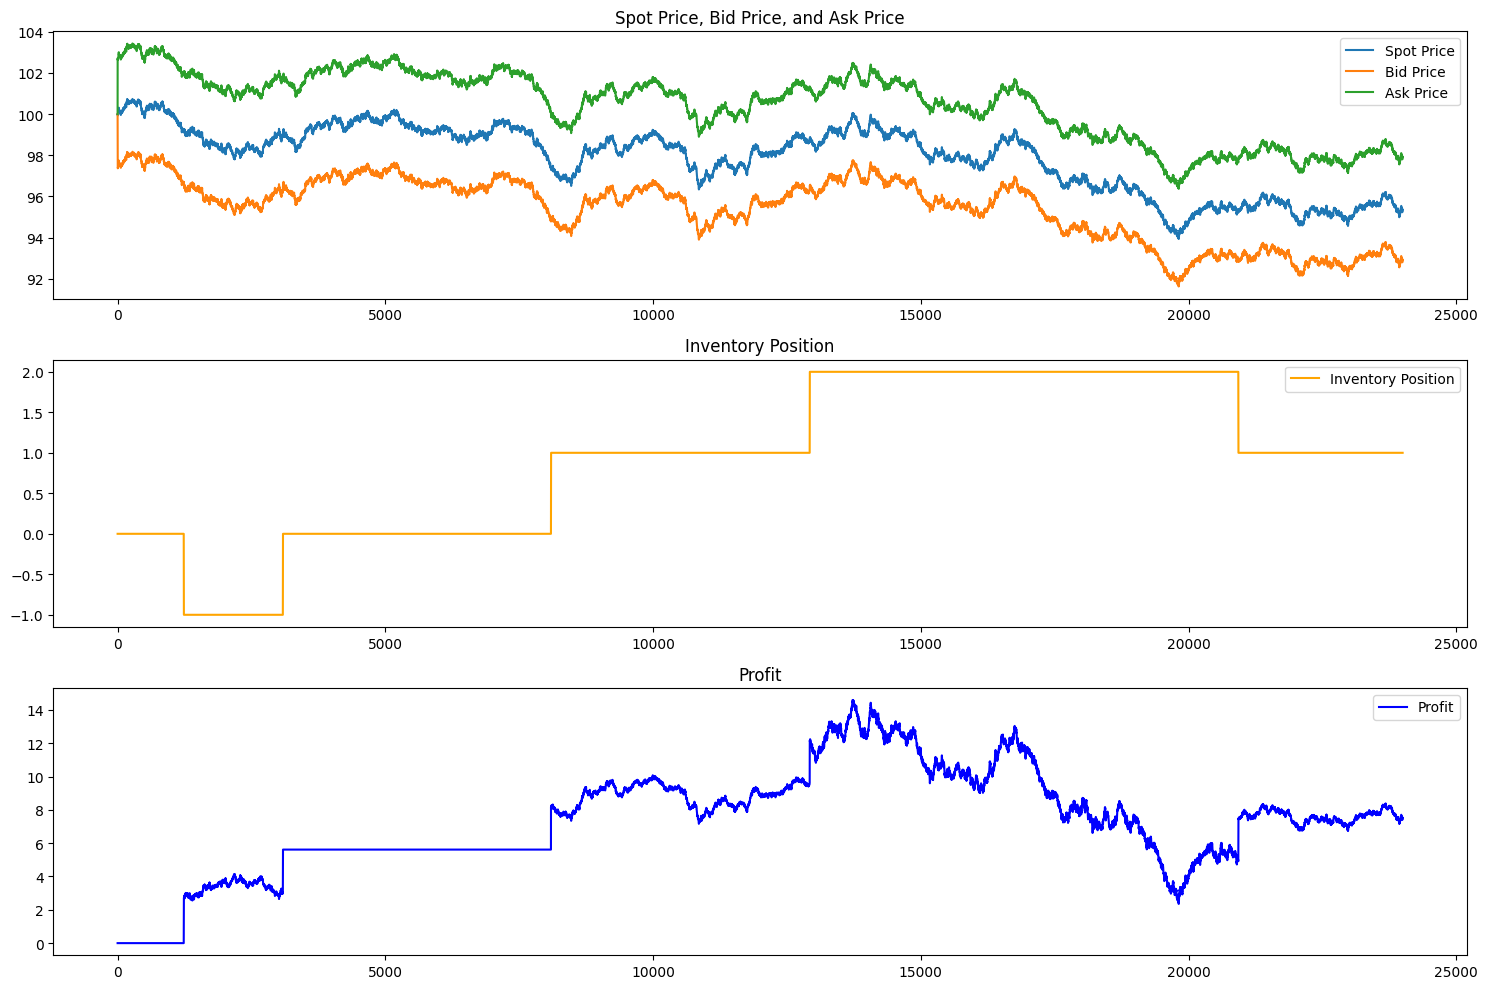

---------STATS--------


Average Spread: 5.02

Max Spread: 5.52


Average Inventory held: 0.92

Maximum Inventory held (Short or Long): 2.00


Generated Profit: 7.44

Profit StDev: 3.07


Sharpe Ratio: 2.42


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="biu")

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
cash = np.zeros(M1+1)
profit = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
q[0] = 0
cash[0] = 0
profit[0] = 0

for t in range(1,M1+1):

    z = np.random.randn()
    S[t] = S[t-1] + sigma1*math.sqrt((T1/M1))*z + mu1*(T1/M1)
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    executed_buy, executed_sell = sim_trad(S=S[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Spot Price, Bid Price, and Ask Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(q, label='Inventory Position', color='orange')
plt.title('Inventory Position')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(profit, label='Profit', color='blue')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}')
print(f'\n\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

We can now do backtesting with the two bots and using a cryptocurrency pair such as BTC/USDT, one of the most important ones. The results are the following:

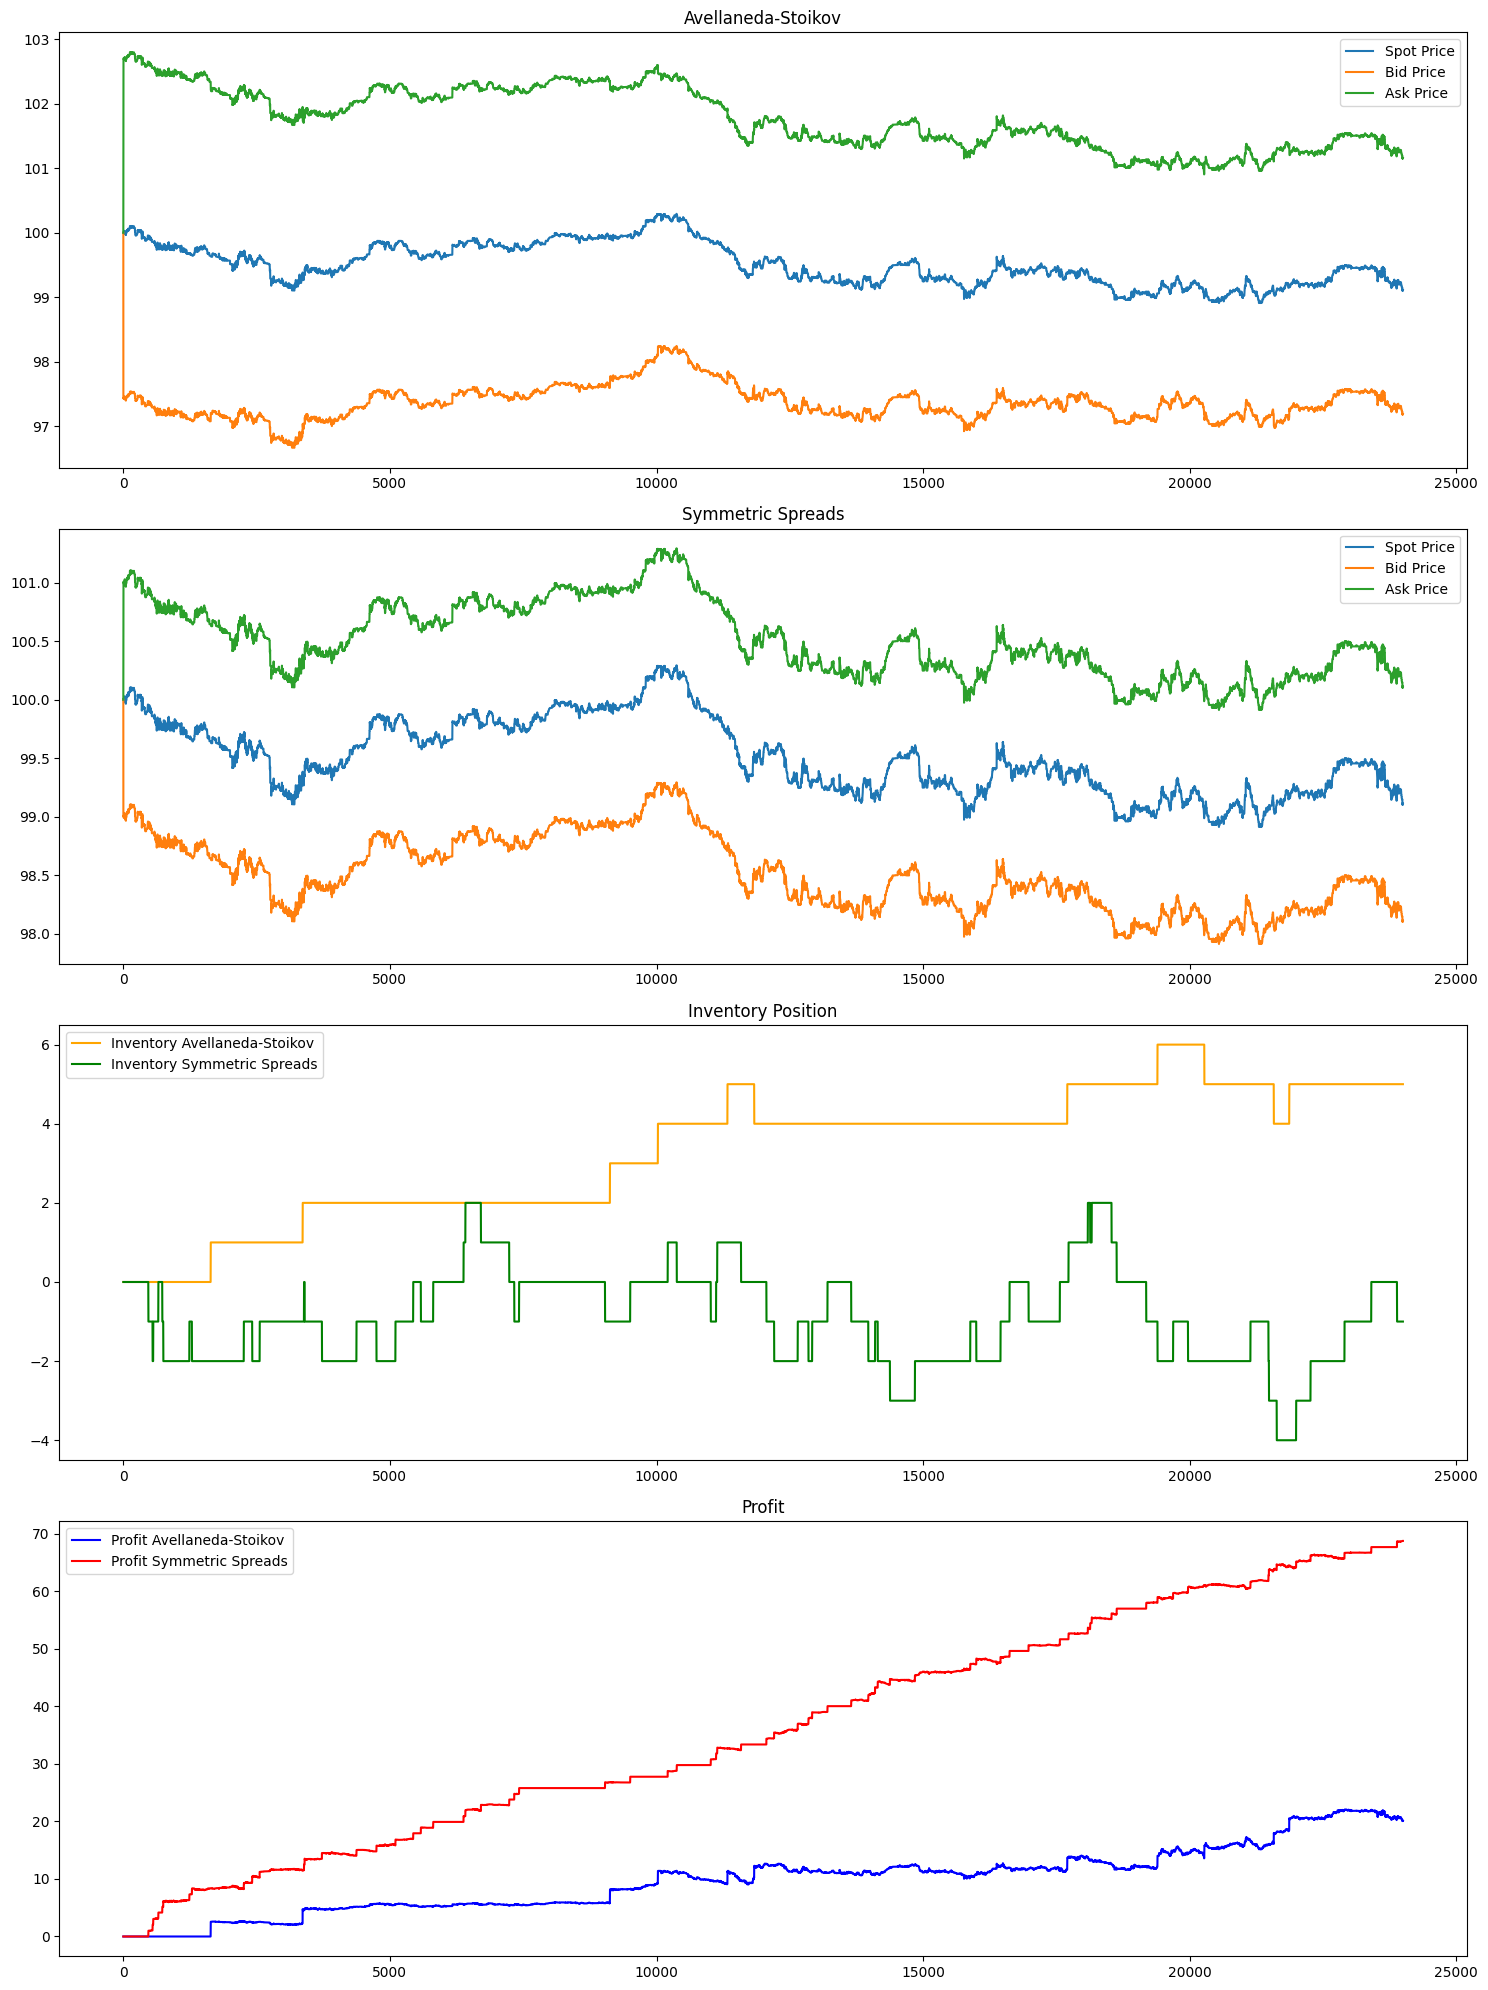

---------STATS--AS---------


Average Spread: 4.40

Max Spread: 5.26


Average Inventory held: 3.30

Maximum Inventory held (Short or Long): 6.00


Generated Profit: 20.11

Profit StDev: 5.65


Sharpe Ratio: 3.56

---------STATS--Sym--------


Average Inventory held: -0.90

Maximum Inventory held (Short or Long): 4.00


Generated Profit: 68.78

Profit StDev: 19.59


Sharpe Ratio: 3.51


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="biu")
sym_bot = Symm(spread=0.02*s0)

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
bids_sym = np.zeros(M1+1)
asks_sym = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
q_sym = np.zeros(M1+1)
cash = np.zeros(M1+1)
cash_sym = np.zeros(M1+1)
profit = np.zeros(M1+1)
profit_sym = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
bids_sym[0] = s0
asks_sym[0] = s0
q[0] = 0
q_sym[0] = 0
cash[0] = 0
cash_sym[0] = 0
profit[0] = 0
profit_sym[0] = 0

for t in range(1,M1+1):

    S[t] = df['Mid-Price'].iloc[t]
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    bids_sym[t], asks_sym[t] = sym_bot.bid_ask(mid_price=S[t])
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    # Avellaneda-Stoikov Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]
        
    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]
    
    # Symmetric Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids_sym[t],ask=asks_sym[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1] + 1
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t]

    elif not executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1] - 1
        cash_sym[t] = cash_sym[t - 1] + asks_sym[t]

    elif not executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1]

    elif executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t] + asks_sym[t]

    profit_sym[t] = cash_sym[t] + q_sym[t] * S[t]

plt.figure(figsize=(15, 20))

# Plot S, Bids, and Asks for Avellaneda-Stoikov

plt.subplot(4, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Avellaneda-Stoikov')
plt.legend()

# Plot S, Bids, and Asks for Symmetric spreads

plt.subplot(4, 1, 2)
plt.plot(S, label='Spot Price')
plt.plot(bids_sym, label='Bid Price')
plt.plot(asks_sym, label='Ask Price')
plt.title('Symmetric Spreads')
plt.legend()

# Plot q for both strategies

plt.subplot(4, 1, 3)
plt.plot(q, label='Inventory Avellaneda-Stoikov', color='orange')
plt.plot(q_sym, label='Inventory Symmetric Spreads', color='green')
plt.title('Inventory Position')
plt.legend()

# Plot profit for both strategies

plt.subplot(4, 1, 4)
plt.plot(profit, label='Profit Avellaneda-Stoikov', color='blue')
plt.plot(profit_sym, label='Profit Symmetric Spreads', color='red')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--AS---------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}\n')
print(f'\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

print('\n---------STATS--Sym--------\n\n')


q_series = pd.Series(q_sym)

print(f'Average Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit_sym[-1]:.2f}\n')
print(f'Profit StDev: {profit_sym.std():.2f}\n')
print(f'\nSharpe Ratio: {profit_sym[-1]/profit_sym.std():.2f}')

#### **The Avellaneda-Stoikov Model Implementation when there is a risk limit, a jump process and an infinite trading horizon ($bij$)**


This is the modified Avellaneda-Stoikov model proposed by Guéant et al. (2012), which extends the results from the original paper to include a risk limitation for the inventory and a jump process when there is an infinite trading horizon. All the aspects are equal to the finite trading horizon with a jump process case (model $bj$), but now the authors compute the limit for $\delta^{b}$ and $\delta^{a}$ and provide a suitable closed-form approximation.

For $\delta^{b}$ and $\delta^{a}$, the limits when $T \rightarrow \infty$ are
$$
\lim_{T\rightarrow \infty} \delta^{b} = \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{1}{k}\ln\left(\frac{\mathcal{f}^0_q}{\mathcal{f}^0_{q+1}}\right)
$$
$$
\lim_{T\rightarrow \infty} \delta^{a} = \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{1}{k}\ln\left(\frac{\mathcal{f}^0_q}{\mathcal{f}^0_{q-1}}\right)
$$

where $\mathcal{f}^0$ is an eigenvector corresponding to the smallest eigenvalue of the matrix

$$
\begin{pmatrix}
\alpha Q^2  & -\eta e^{-\frac{k}{2}\xi}& 0 & \cdots & \cdots & 0 & 0 \\
-\eta e^{-\frac{k}{2}\xi} & \alpha (Q-1)^2 & - \eta e^{-\frac{k}{2}\xi}& \cdots & \cdots & \vdots & \vdots \\
0 & -\eta e^{-\frac{k}{2}\xi} & \alpha (Q-2)^2 & \cdots & \ddots & \vdots & \vdots \\
\vdots & 0 & -\eta e^{-\frac{k}{2}\xi}& \ddots & \ddots & - \eta e^{-\frac{k}{2}\xi}& \vdots \\
\vdots & \vdots & 0 & \cdots & -\eta e^{-\frac{k}{2}\xi}& \alpha (Q-1)^2 & -\eta e^{-\frac{k}{2}\xi}\\
\vdots & \vdots & \vdots & \cdots & 0 & -\eta e^{-\frac{k}{2}\xi}& \alpha Q^2
\end{pmatrix}
$$

Because it is cumbersome to find a closed-form representation for $\mathcal{f}^0$, the authors offer a closed-form approximation for both results which simplify the usage of the bid and ask prices distances for optimal trading:
$$
\lim_{T\rightarrow \infty} \delta^{b} \approx \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{\xi}{2}+\frac{2q+1}{2}e^{-\frac{k}{4}\xi}\sqrt{\frac{\sigma^2 \gamma}{2kA}\left(1+\frac{\gamma}{k}\right)^{1+k/\gamma}}
$$
$$
\lim_{T\rightarrow \infty} \delta^{a} \approx \frac{1}{\gamma} \ln\left(1+\frac{\gamma}{k}\right)+\frac{\xi}{2}-\frac{2q-1}{2}e^{-\frac{k}{4}\xi}\sqrt{\frac{\sigma^2 \gamma}{2kA}\left(1+\frac{\gamma}{k}\right)^{1+k/\gamma}}
$$

The numerical simulation results of this model are summarized below:

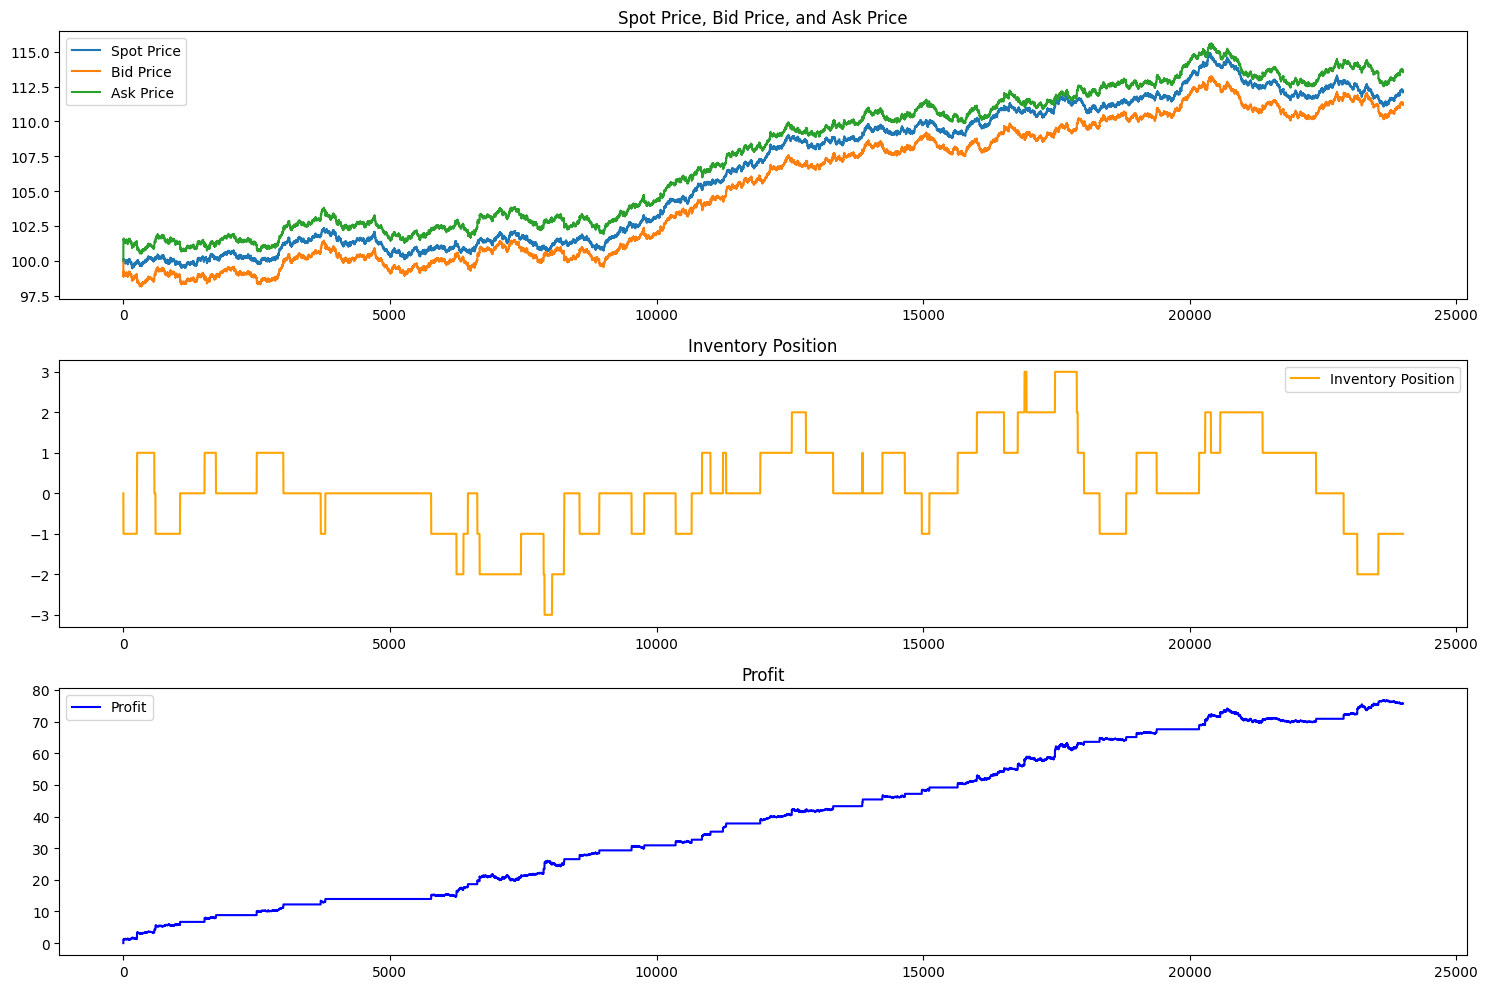

---------STATS--------


Average Spread: 2.36

Max Spread: 2.36


Average Inventory held: 0.15

Maximum Inventory held (Short or Long): 3.00


Generated Profit: 75.75

Profit StDev: 23.03


Sharpe Ratio: 3.29


In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bij")

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
cash = np.zeros(M1+1)
profit = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
q[0] = 0
cash[0] = 0
profit[0] = 0

for t in range(1,M1+1):

    z = np.random.randn()
    
    if np.random.rand() < random.expovariate(A1*math.exp(-k1*(asks[t-1]-S[t-1]))):
        dNa = 1
    else:
        dNa = 0
    
    if np.random.rand() < random.expovariate(A1*math.exp(-k1*(S[t-1]-bids[t-1]))):
        dNb = 1
    else:
        dNb = 0

    S[t] = S[t-1] + sigma1*math.sqrt((T1/M1))*z + eps1*(dNa-dNb)*(T1/M1)
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    executed_buy, executed_sell = sim_trad(S=S[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]

    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Spot Price, Bid Price, and Ask Price')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(q, label='Inventory Position', color='orange')
plt.title('Inventory Position')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(profit, label='Profit', color='blue')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}')
print(f'\n\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

We can now do backtesting with the two bots and using a cryptocurrency pair such as BTC/USDT, one of the most important ones. The results are the following:

In [ ]:
av_st_bot = AveStoikov(gamma=gamma1,k=k1,A=A1,Q=Q1,eps=eps1,mod="bij")
sym_bot = Symm(spread=0.02*s0)

S = np.zeros(M1+1)
bids = np.zeros(M1+1)
asks = np.zeros(M1+1)
bids_sym = np.zeros(M1+1)
asks_sym = np.zeros(M1+1)
spreads = np.zeros(M1+1)
q = np.zeros(M1+1)
q_sym = np.zeros(M1+1)
cash = np.zeros(M1+1)
cash_sym = np.zeros(M1+1)
profit = np.zeros(M1+1)
profit_sym = np.zeros(M1+1)

S[0] = s0
bids[0] = s0
asks[0] = s0
bids_sym[0] = s0
asks_sym[0] = s0
q[0] = 0
q_sym[0] = 0
cash[0] = 0
cash_sym[0] = 0
profit[0] = 0
profit_sym[0] = 0

for t in range(1,M1+1):

    S[t] = df['Mid-Price'].iloc[t]
    v_t = av_st_bot.vt_creation(sigma=sigma1,T=T1,t=t,M=M1)

    bids[t], asks[t] = av_st_bot.opt_bidask(S=S[t],sigma=sigma1,q=q[t-1],T=T1,t=t,M=M1,v=v_t,mu=mu1)
    bids_sym[t], asks_sym[t] = sym_bot.bid_ask(mid_price=S[t])
    spreads[t] = av_st_bot.strat_spread(bid=bids[t], ask=asks[t])

    # Avellaneda-Stoikov Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids[t],ask=asks[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q[t] = q[t - 1] + 1
        cash[t] = cash[t - 1] - bids[t]
        
    elif not executed_buy and executed_sell:
        q[t] = q[t - 1] - 1
        cash[t] = cash[t - 1] + asks[t]

    elif not executed_buy and not executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1]

    elif executed_buy and executed_sell:
        q[t] = q[t - 1]
        cash[t] = cash[t - 1] - bids[t] + asks[t]

    profit[t] = cash[t] + q[t] * S[t]
    
    # Symmetric Bot

    executed_buy, executed_sell = backtest_order(ob_bid=df["OrderBook_Bid"].iloc[t],ob_ask=df["OrderBook_Ask"].iloc[t],bid=bids_sym[t],ask=asks_sym[t],k=k1,A=A1,T=T1,M=M1)

    if executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1] + 1
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t]

    elif not executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1] - 1
        cash_sym[t] = cash_sym[t - 1] + asks_sym[t]

    elif not executed_buy and not executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1]

    elif executed_buy and executed_sell:
        q_sym[t] = q_sym[t - 1]
        cash_sym[t] = cash_sym[t - 1] - bids_sym[t] + asks_sym[t]

    profit_sym[t] = cash_sym[t] + q_sym[t] * S[t]

plt.figure(figsize=(15, 20))

# Plot S, Bids, and Asks for Avellaneda-Stoikov

plt.subplot(4, 1, 1)
plt.plot(S, label='Spot Price')
plt.plot(bids, label='Bid Price')
plt.plot(asks, label='Ask Price')
plt.title('Avellaneda-Stoikov')
plt.legend()

# Plot S, Bids, and Asks for Symmetric spreads

plt.subplot(4, 1, 2)
plt.plot(S, label='Spot Price')
plt.plot(bids_sym, label='Bid Price')
plt.plot(asks_sym, label='Ask Price')
plt.title('Symmetric Spreads')
plt.legend()

# Plot q for both strategies

plt.subplot(4, 1, 3)
plt.plot(q, label='Inventory Avellaneda-Stoikov', color='orange')
plt.plot(q_sym, label='Inventory Symmetric Spreads', color='green')
plt.title('Inventory Position')
plt.legend()

# Plot profit for both strategies

plt.subplot(4, 1, 4)
plt.plot(profit, label='Profit Avellaneda-Stoikov', color='blue')
plt.plot(profit_sym, label='Profit Symmetric Spreads', color='red')
plt.title('Profit')
plt.legend()

plt.tight_layout()
plt.show()

print('---------STATS--AS---------\n\n')

spreads_series = pd.Series(spreads)
q_series = pd.Series(q)

print(f'Average Spread: {np.mean(spreads_series):.2f}\n')
print(f'Max Spread: {max(spreads_series):.2f}\n')
print(f'\nAverage Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit[-1]:.2f}\n')
print(f'Profit StDev: {profit.std():.2f}\n')
print(f'\nSharpe Ratio: {profit[-1]/profit.std():.2f}')

print('\n---------STATS--Sym--------\n\n')


q_series = pd.Series(q_sym)

print(f'Average Inventory held: {np.mean(q_series):.2f}\n')
print(f'Maximum Inventory held (Short or Long): {max(abs(q_series)):.2f}\n')
print(f'\nGenerated Profit: {profit_sym[-1]:.2f}\n')
print(f'Profit StDev: {profit_sym.std():.2f}\n')
print(f'\nSharpe Ratio: {profit_sym[-1]/profit_sym.std():.2f}')

---------STATS--AS---------


Average Spread: 2.36

Max Spread: 2.36


Average Inventory held: -0.65

Maximum Inventory held (Short or Long): 3.00


Generated Profit: 55.68

Profit StDev: 15.36


Sharpe Ratio: 3.62

---------STATS--Sym--------


Average Inventory held: 4.94

Maximum Inventory held (Short or Long): 11.00


Generated Profit: 56.52

Profit StDev: 15.75


Sharpe Ratio: 3.59
